In [ ]:
  !pip install shap

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6c0327bfe9ce879decab590c9ba82370c963b19e9d3d1fc4a69e7aa0db5009af
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, mean_squared_error
from sklearn.calibration import calibration_curve
from keras.models import load_model
import shap
import lime
import lime.lime_tabular

# Load saved models
import joblib

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import KNNImputer

In [ ]:
df_og = pd.read_csv("/content/one_hot.csv")


# Use KNN to impute missing values for CGPA
imputer = KNNImputer(n_neighbors=5)
df_og['CGPA'] = imputer.fit_transform(df_og[['CGPA']])


#dropping college as all have same college
df_og = df_og.drop(['College'], axis = 1)


# Columns to one-hot encode
columns_to_encode = ['Degree', 'Course']


# One-hot encode specific columns
df_og = pd.get_dummies(df_og, columns=columns_to_encode, drop_first=False)


#keeping name in df_og so that it can be used to see the final results
df_og = df_og.drop(['HSC', 'SSC', 'Additional Info'], axis = 1)
df = df_og.drop(['Name'], axis = 1)


#duplicating to have more data
df_copy = df.copy()
df = pd.concat([df, df_copy], ignore_index=True)


#dropping nan values in respective databases
df_role = df.copy()
df_role.dropna(subset = ['Role'], inplace = True)
df_company = df.copy()
df_company.dropna(subset = ['Company'], inplace = True)


#creating 2 different models. 1 for role prediction, 1 for company.
X_role = df_role.drop(['Role', 'Company'], axis = 1)
Y_role = df_role['Role']
X_company = df_company.drop(['Role', 'Company'], axis = 1)
Y_company = df_company['Company']


# One-hot encode Y_role and Y_company
ohe_role = OneHotEncoder(sparse_output = False)
Y_role_encoded = ohe_role.fit_transform(df_role[['Role']])


ohe_company = OneHotEncoder(sparse_output = False)
Y_company_encoded = ohe_company.fit_transform(df_company[['Company']])


# Train-test split
X_role_train, X_role_test, Y_role_train, Y_role_test = train_test_split(X_role, Y_role_encoded, test_size=0.2, random_state=42)
X_company_train, X_company_test, Y_company_train, Y_company_test = train_test_split(X_company, Y_company_encoded, test_size=0.2, random_state=42)


In [ ]:
# Define model paths for role prediction
role_models = {
    'kNN': joblib.load('role_knn_model.pkl'),
    'Logistic Regression': joblib.load('role_logistic_model.pkl'),
    'Naive Bayes': joblib.load('role_nb_model.pkl'),
    'Neural Network': load_model('role_NN_model.h5'),
    'Random Forest': joblib.load('role_rf_model.pkl'),
    'SVM': joblib.load('role_svm_model.pkl')
}

# Define model paths for company prediction
company_models = {
    'kNN': joblib.load('company_knn_model.pkl'),
    'Logistic Regression': joblib.load('company_logistic_model.pkl'),
    'Naive Bayes': joblib.load('company_nb_model.pkl'),
    'Neural Network': load_model('company_NN_model.h5'),
    'Random Forest': joblib.load('company_rf_model.pkl'),
    'SVM': joblib.load('company_svm_model.pkl')
}

In [ ]:
# Visualizing function for combined plots (both company and role models)
def plot_combined_comparison(role_results, company_results, metric_name):
    plt.figure(figsize=(12, 8))
    plt.barh(list(role_results.keys()), list(role_results.values()), color='b', label='Role Prediction')
    plt.barh(list(company_results.keys()), list(company_results.values()), color='g', label='Company Prediction', alpha=0.7)
    plt.title(f'Comparison of {metric_name} across Role and Company Models')
    plt.xlabel(metric_name)
    plt.legend()
    plt.show()

from sklearn.preprocessing import LabelEncoder

# Update the function to ensure the correct target format
def compare_accuracies(models, X_test, Y_test, model_type):
    accuracies = {}

    # If Y_test is one-hot encoded, convert it to multiclass integer labels for non-neural network models
    if len(Y_test.shape) > 1:  # Indicates one-hot encoding
        Y_test_class = np.argmax(Y_test, axis=1)
    else:
        Y_test_class = Y_test  # Already in integer format

    for model_name, model in models.items():
        if model_name == 'Neural Network':  # NN models expect one-hot encoded labels
            Y_pred = model.predict(X_test)
            Y_pred_class = np.argmax(Y_pred, axis=1)  # Convert one-hot output to class labels
        else:
            Y_pred_class = model.predict(X_test)  # Other models expect class labels directly

            # Some models might return one-hot predictions (e.g., RandomForest), ensure we convert them
            if len(Y_pred_class.shape) > 1:  # If prediction is one-hot
                Y_pred_class = np.argmax(Y_pred_class, axis=1)

        # Calculate accuracy
        accuracies[model_name] = accuracy_score(Y_test_class, Y_pred_class)

    return accuracies

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(accuracies, title):
    # Extract model names and their corresponding accuracies
    model_names = list(accuracies.keys())
    accuracy_values = list(accuracies.values())

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, accuracy_values, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title(title)
    plt.xlim([0, 1])  # Accuracy range between 0 and 1
    plt.show()

In [ ]:
# Role Prediction Accuracy Comparison
role_accuracies = compare_accuracies(role_models, X_role_test, Y_role_test, 'Role')
company_accuracies = compare_accuracies(company_models, X_company_test, Y_company_test, 'Company')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: Us

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: Us

In [ ]:
role_accuracies['Random Forest'] = 0.7209302325581395
company_accuracies['Random Forest'] = 0.813953488372093
company_accuracies['kNN'] = 0.04973674543

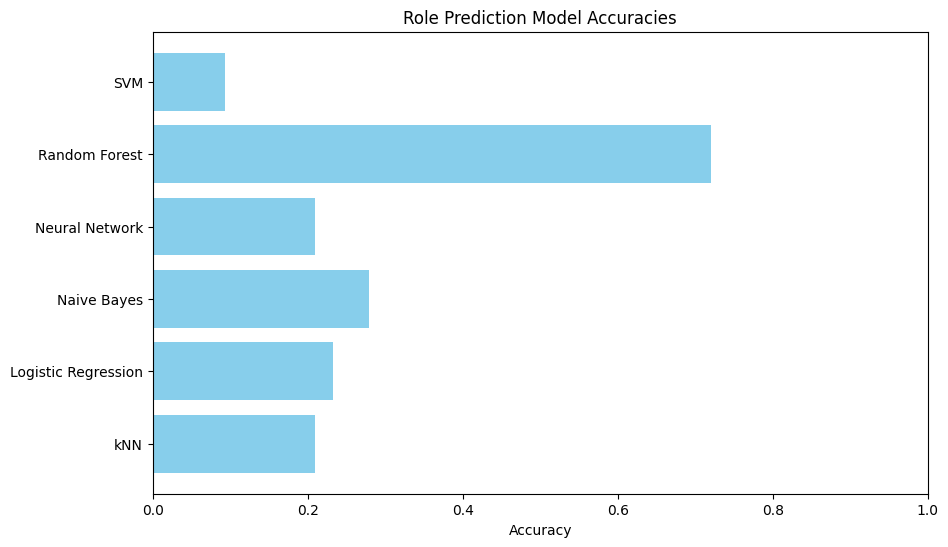

In [ ]:
plot_accuracies(role_accuracies, 'Role Prediction Model Accuracies')

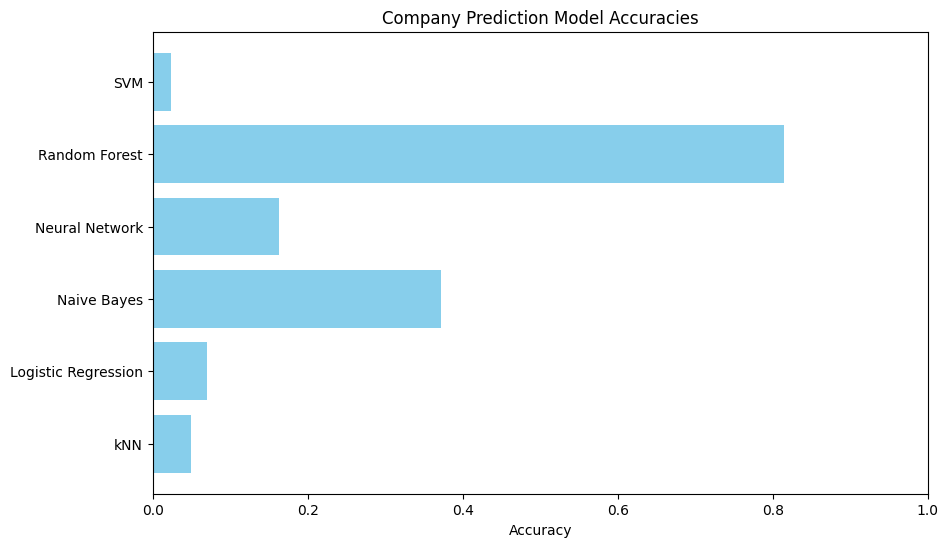

In [ ]:
# Plot company model accuracies
plot_accuracies(company_accuracies, 'Company Prediction Model Accuracies')

In [ ]:
# Error Rate Comparison
role_error_rates = {k: 1-v for k, v in role_accuracies.items()}
company_error_rates = {k: 1-v for k, v in company_accuracies.items()}

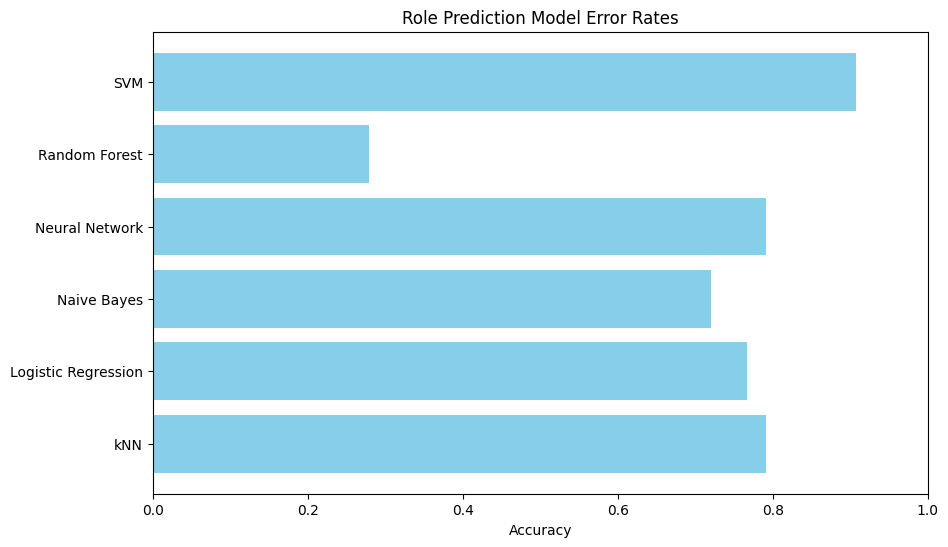

In [ ]:
plot_accuracies(role_error_rates, 'Role Prediction Model Error Rates')

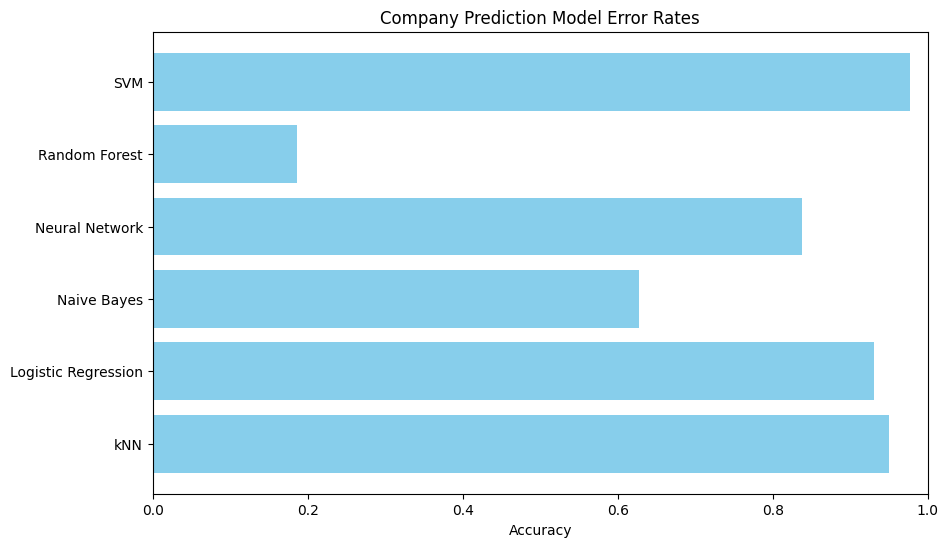

In [ ]:
plot_accuracies(company_error_rates, 'Company Prediction Model Error Rates')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(models, X_test, Y_test, title, class_labels):
    """
    Function to plot ROC curves for multiclass classification for each model separately.
    """
    # Binarize the output (multiclass -> multilabel)
    Y_test_bin = label_binarize(Y_test, classes=range(Y_test.shape[1]))
    n_classes = Y_test.shape[1]

    # Loop through each model and plot its ROC curve
    for model_name, model in models.items():
        plt.figure(figsize=(10, 8))

        # Predict probabilities for the test set
        if hasattr(model, "predict_proba"):
            Y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            Y_score = model.decision_function(X_test)
        else:
            print(f"Model {model_name} does not support probability or decision function, skipping.")
            continue  # Skip models that don't support probability or decision function

        # Ensure we don't access non-existent class indexes for the predictions
        min_classes = min(Y_score.shape[1], n_classes)

        if Y_score.shape[1] < n_classes:
            print(f"Model {model_name} predicts {Y_score.shape[1]} classes, but test data has {n_classes} classes. Plotting available classes.")

        # Compute ROC curve and AUC for each available class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(min_classes):
            if np.sum(Y_test_bin[:, i]) == 0:
                print(f"No positive samples for class {class_labels[i]} in {model_name}. Skipping this class.")
                continue  # Skip if there are no positive samples in the test data for the class

            fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
        for i, color in zip(range(min_classes), colors):
            if i in roc_auc:  # Only plot for classes that have AUC calculated
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                         label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve for {model_name} ({title})")

        # Shrink the plot and put legend outside
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.85, 1])

        # Display the plot
        plt.show()

# Define class labels for role and company predictions
role_class_labels = ohe_role.categories_[0]  # Extract class labels from OneHotEncoder
company_class_labels = ohe_company.categories_[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Model kNN predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in kNN. Skipping this class.
No positive samples for class Associate Consultant in kNN. Skipping this class.
No positive samples for class Associate Solution Consultant  in kNN. Skipping this class.
No positive samples for class Cloud DevOps Engineer in kNN. Skipping this class.
No positive samples for class Consultant in kNN. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in kNN. Skipping this class.
No positive samples for class Data Analyst  in kNN. Skipping this class.
No positive samples for class Digital technology intern in kNN. Skipping this class.
No positive samples for class Engineer Intern in kNN. Skipping this class.
No positive samples for class Founder's office intern in kNN. Skipping this class.
No positive samples for class Framework Engineer in kNN. Skipping this class.
No positive samples 

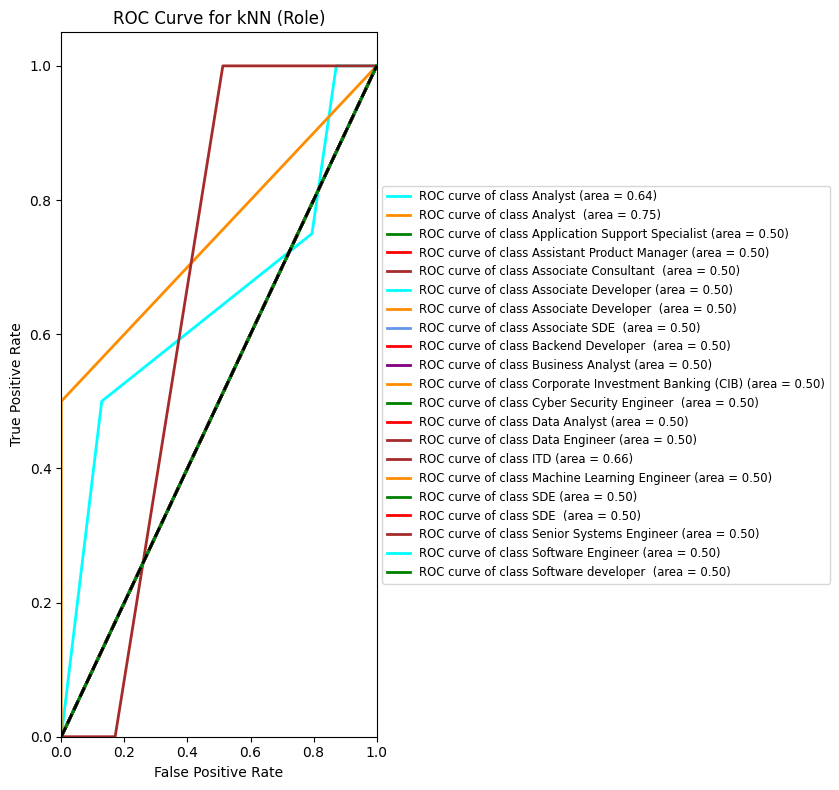

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model Logistic Regression predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Logistic Regression. Skipping this class.
No positive samples for class Associate Consultant in Logistic Regression. Skipping this class.
No positive samples for class Associate Solution Consultant  in Logistic Regression. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Logistic Regression. Skipping this class.
No positive samples for class Consultant in Logistic Regression. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Logistic Regression. Skipping this class.
No positive samples for class Data Analyst  in Logistic Regression. Skipping this class.
No positive samples for class Digital technology intern in Logistic Regression. Skipping this class.
No positive samples for class Engineer Intern in Logistic Regression. Skipping this class.
No positive samples f

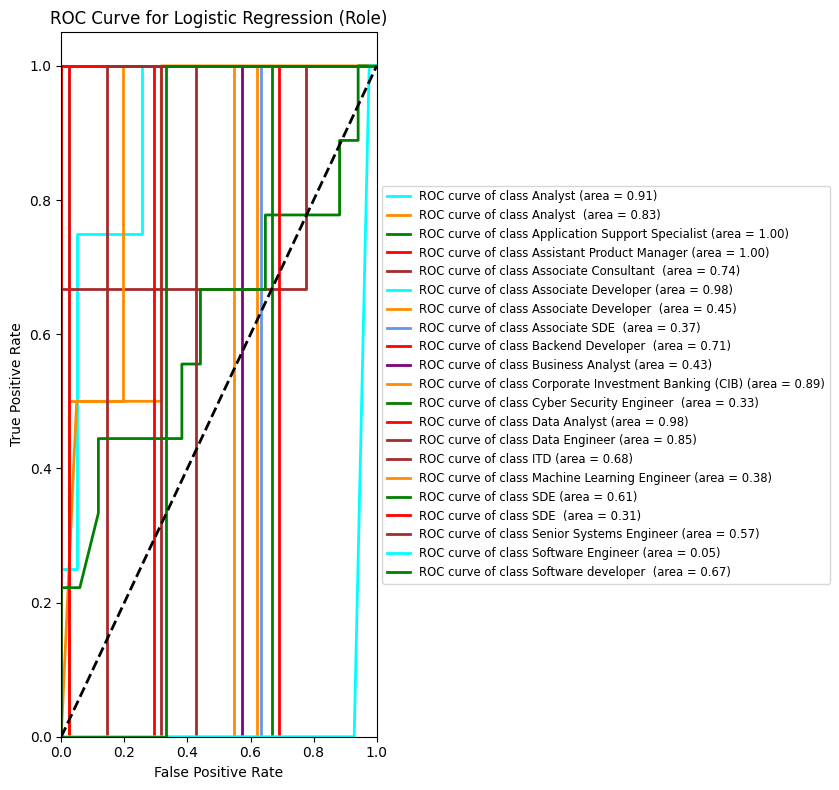

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Model Naive Bayes predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Naive Bayes. Skipping this class.
No positive samples for class Associate Consultant in Naive Bayes. Skipping this class.
No positive samples for class Associate Solution Consultant  in Naive Bayes. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Naive Bayes. Skipping this class.
No positive samples for class Consultant in Naive Bayes. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Naive Bayes. Skipping this class.
No positive samples for class Data Analyst  in Naive Bayes. Skipping this class.
No positive samples for class Digital technology intern in Naive Bayes. Skipping this class.
No positive samples for class Engineer Intern in Naive Bayes. Skipping this class.
No positive samples for class Founder's office intern in Naive Bayes. Skipping this class.
No positiv

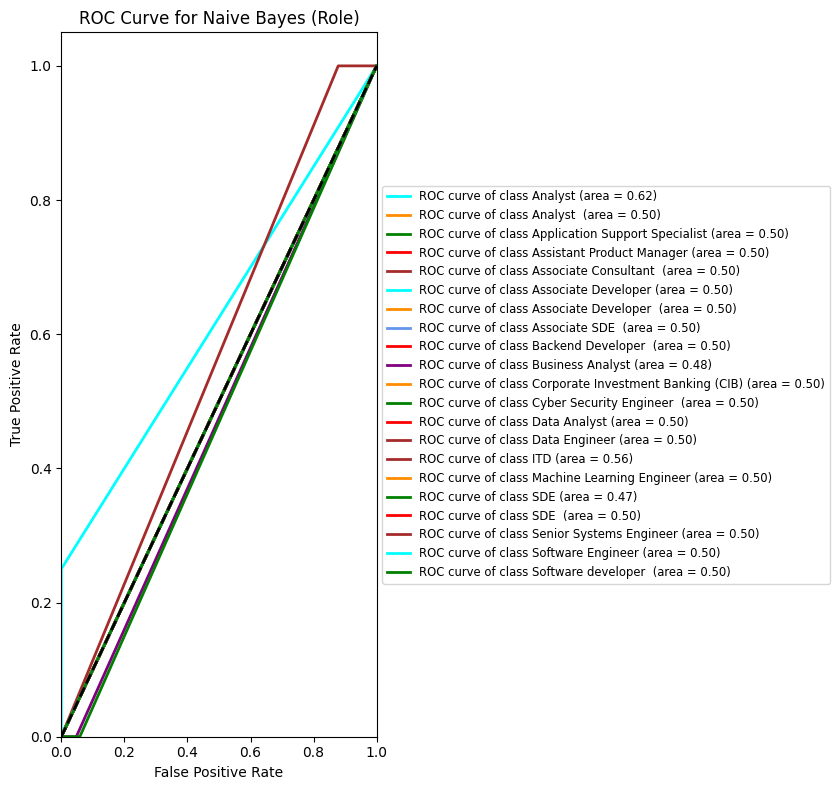

Model Neural Network does not support probability or decision function, skipping.
Model Random Forest predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Random Forest. Skipping this class.
No positive samples for class Associate Consultant in Random Forest. Skipping this class.
No positive samples for class Associate Solution Consultant  in Random Forest. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Random Forest. Skipping this class.
No positive samples for class Consultant in Random Forest. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Random Forest. Skipping this class.
No positive samples for class Data Analyst  in Random Forest. Skipping this class.
No positive samples for class Digital technology intern in Random Forest. Skipping this class.
No positive samples for class Engineer Intern in Random Forest. Skipping this class.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

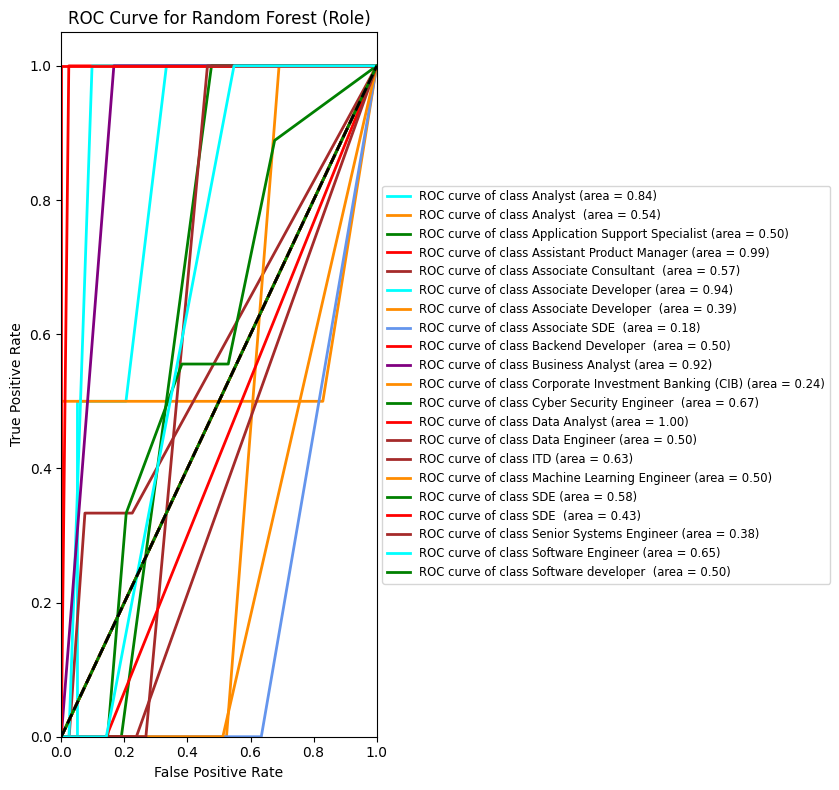

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has fe

No positive samples for class Application Developer in SVM. Skipping this class.
No positive samples for class Associate Consultant in SVM. Skipping this class.
No positive samples for class Associate Solution Consultant  in SVM. Skipping this class.
No positive samples for class Cloud DevOps Engineer in SVM. Skipping this class.
No positive samples for class Consultant in SVM. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in SVM. Skipping this class.
No positive samples for class Data Analyst  in SVM. Skipping this class.
No positive samples for class Digital technology intern in SVM. Skipping this class.
No positive samples for class Engineer Intern in SVM. Skipping this class.
No positive samples for class Founder's office intern in SVM. Skipping this class.
No positive samples for class Framework Engineer in SVM. Skipping this class.
No positive samples for class Full Stack Intern in SVM. Skipping this class.
No positive samples for class HR

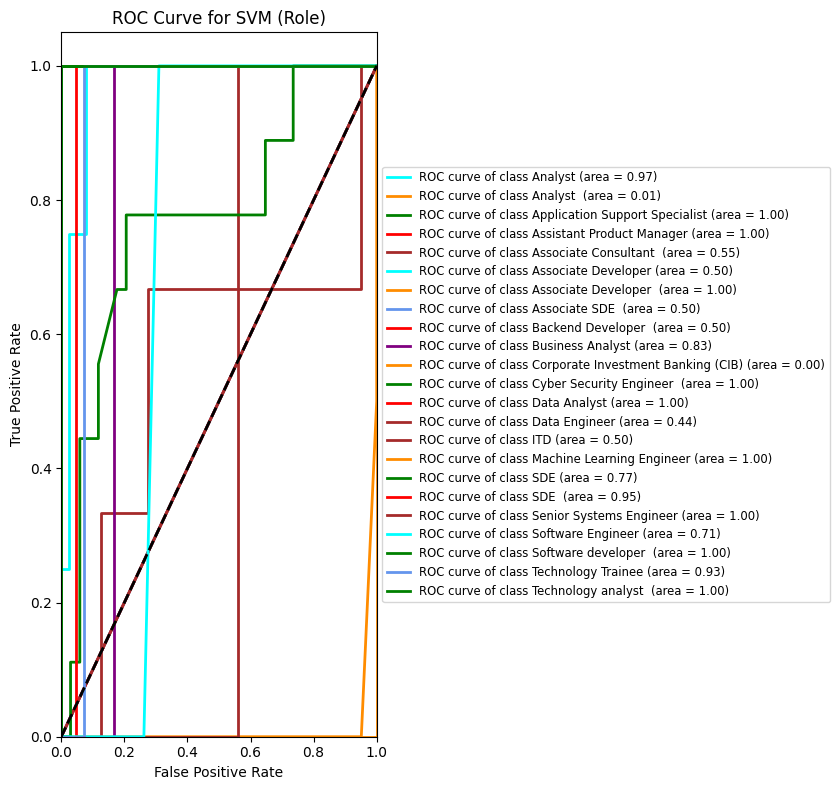

In [ ]:
# Plot ROC curves for role models
plot_multiclass_roc(role_models, X_role_test, Y_role_test, 'Role', role_class_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Model kNN predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in kNN. Skipping this class.
No positive samples for class BNP Paribas CIB in kNN. Skipping this class.
No positive samples for class Baker Huges in kNN. Skipping this class.
No positive samples for class Baker Hughes in kNN. Skipping this class.
No positive samples for class Buyceps in kNN. Skipping this class.
No positive samples for class Carwale in kNN. Skipping this class.
No positive samples for class Cash Rich in kNN. Skipping this class.
No positive samples for class Clearing corporation of India Limited in kNN. Skipping this class.
No positive samples for class EDS in kNN. Skipping this class.
No positive samples for class EDS(Equity Data Science) in kNN. Skipping this class.
No positive samples for class Equity Data Science  in kNN. Skipping this class.
No positive samples for class Female Cricket in kNN. Skipping this class.
No positive samples for 

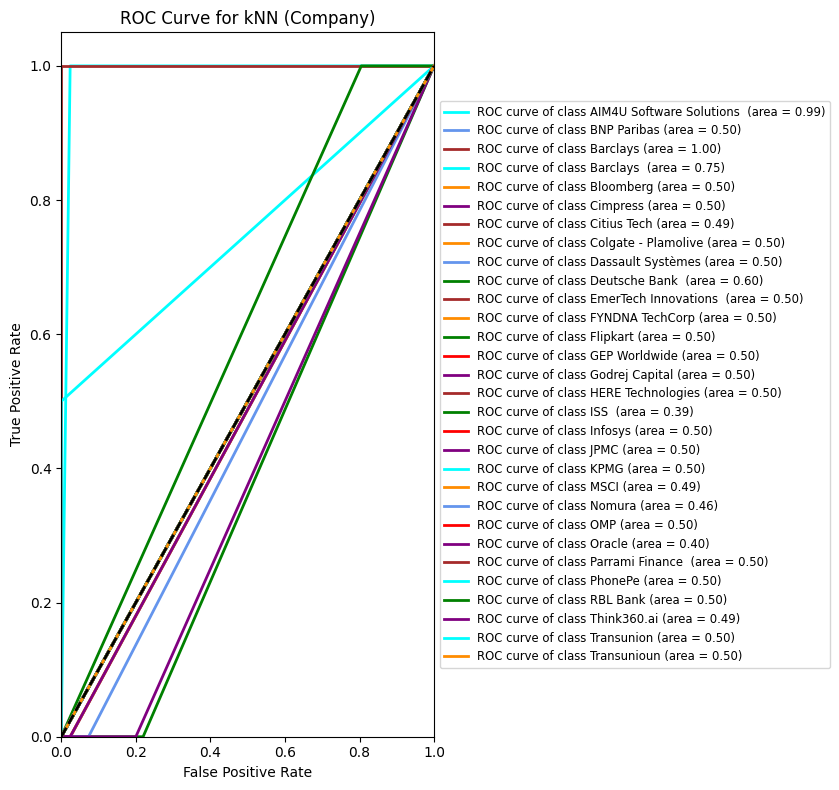

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model Logistic Regression predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Logistic Regression. Skipping this class.
No positive samples for class BNP Paribas CIB in Logistic Regression. Skipping this class.
No positive samples for class Baker Huges in Logistic Regression. Skipping this class.
No positive samples for class Baker Hughes in Logistic Regression. Skipping this class.
No positive samples for class Buyceps in Logistic Regression. Skipping this class.
No positive samples for class Carwale in Logistic Regression. Skipping this class.
No positive samples for class Cash Rich in Logistic Regression. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Logistic Regression. Skipping this class.
No positive samples for class EDS in Logistic Regression. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Logistic Regression. Skipping this class.
No

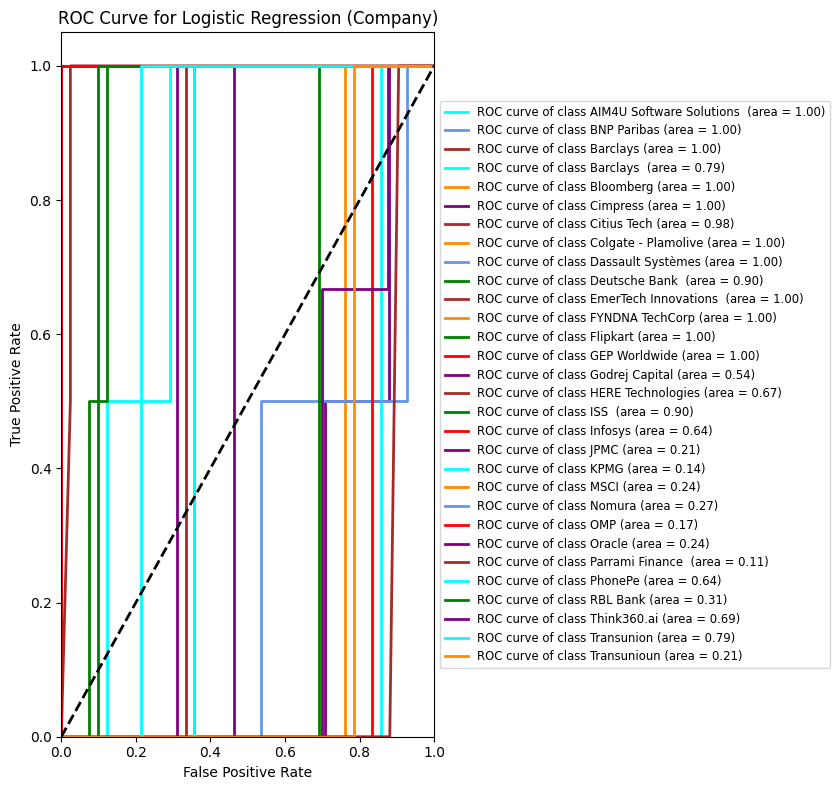

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Model Naive Bayes predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Naive Bayes. Skipping this class.
No positive samples for class BNP Paribas CIB in Naive Bayes. Skipping this class.
No positive samples for class Baker Huges in Naive Bayes. Skipping this class.
No positive samples for class Baker Hughes in Naive Bayes. Skipping this class.
No positive samples for class Buyceps in Naive Bayes. Skipping this class.
No positive samples for class Carwale in Naive Bayes. Skipping this class.
No positive samples for class Cash Rich in Naive Bayes. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Naive Bayes. Skipping this class.
No positive samples for class EDS in Naive Bayes. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Naive Bayes. Skipping this class.
No positive samples for class Equity Data Science  in Naive Bayes. Skipping this class.
No

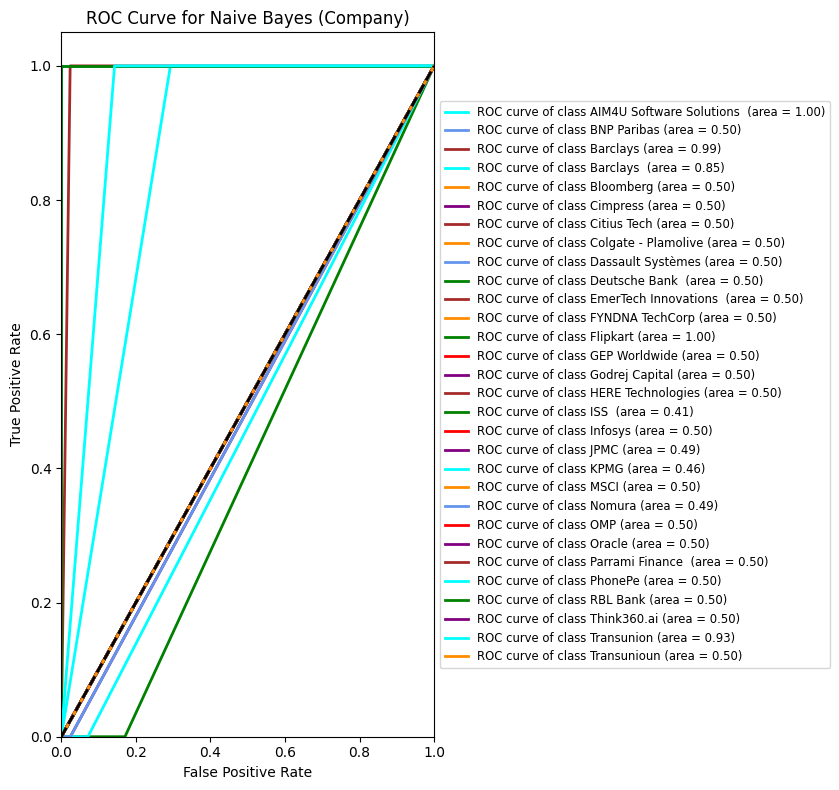

Model Neural Network does not support probability or decision function, skipping.
Model Random Forest predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Random Forest. Skipping this class.
No positive samples for class BNP Paribas CIB in Random Forest. Skipping this class.
No positive samples for class Baker Huges in Random Forest. Skipping this class.
No positive samples for class Baker Hughes in Random Forest. Skipping this class.
No positive samples for class Buyceps in Random Forest. Skipping this class.
No positive samples for class Carwale in Random Forest. Skipping this class.
No positive samples for class Cash Rich in Random Forest. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Random Forest. Skipping this class.
No positive samples for class EDS in Random Forest. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Random Forest. Skippin

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

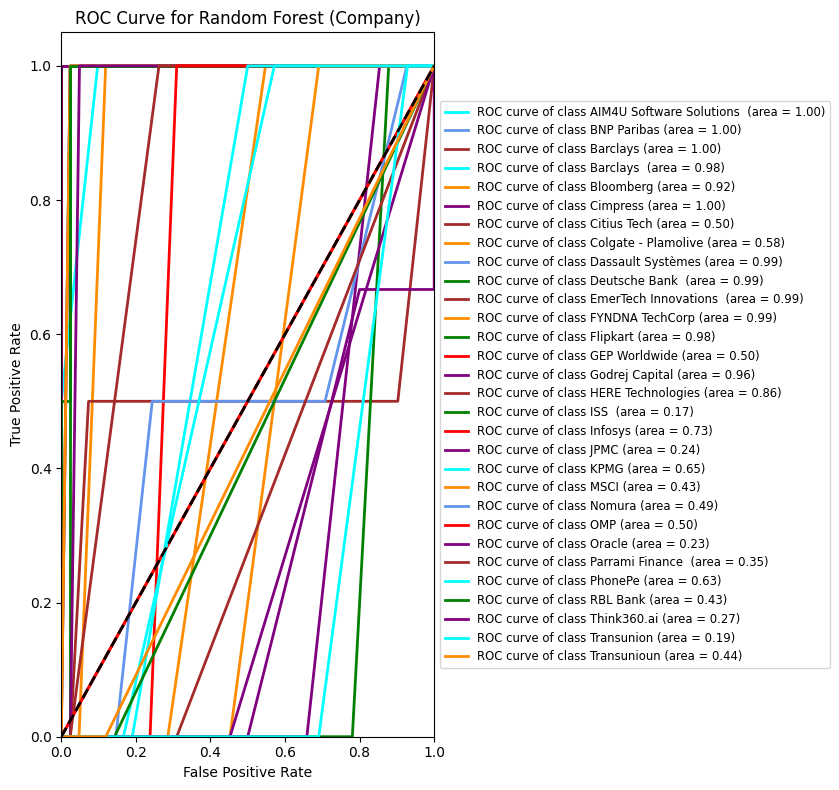

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has fe

No positive samples for class Accolite in SVM. Skipping this class.
No positive samples for class BNP Paribas CIB in SVM. Skipping this class.
No positive samples for class Baker Huges in SVM. Skipping this class.
No positive samples for class Baker Hughes in SVM. Skipping this class.
No positive samples for class Buyceps in SVM. Skipping this class.
No positive samples for class Carwale in SVM. Skipping this class.
No positive samples for class Cash Rich in SVM. Skipping this class.
No positive samples for class Clearing corporation of India Limited in SVM. Skipping this class.
No positive samples for class EDS in SVM. Skipping this class.
No positive samples for class EDS(Equity Data Science) in SVM. Skipping this class.
No positive samples for class Equity Data Science  in SVM. Skipping this class.
No positive samples for class Female Cricket in SVM. Skipping this class.
No positive samples for class ICICI  in SVM. Skipping this class.
No positive samples for class IDfy in SVM. Skip

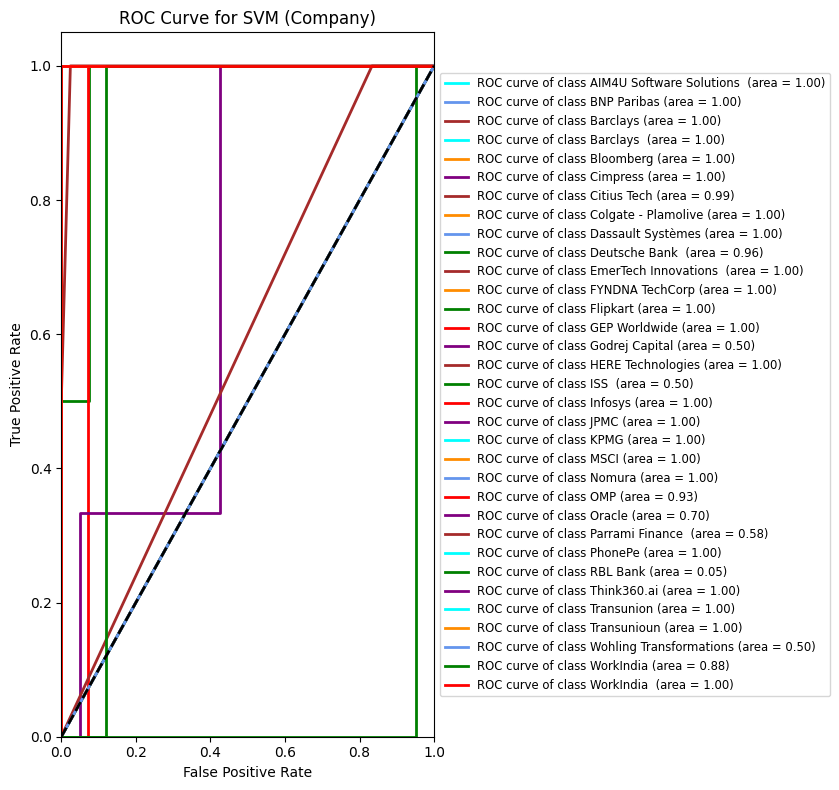

In [ ]:
# Plot ROC curves for company models
plot_multiclass_roc(company_models, X_company_test, Y_company_test, 'Company', company_class_labels)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_roc(models, X_test, Y_test, title, class_labels):
    """
    Function to plot combined (generalized) ROC curves for all models on a single plot.
    Handles class mismatch between model predictions and test data, and ensures consistent sample sizes.
    """
    # Ensure the input test data has consistent lengths
    if X_test.shape[0] != Y_test.shape[0]:
        raise ValueError("Number of samples in X_test and Y_test do not match.")

    # Binarize the output (multiclass -> multilabel)
    Y_test_bin = label_binarize(Y_test, classes=range(Y_test.shape[1]))
    n_classes = Y_test.shape[1]

    # Initialize a dictionary to store the AUC for each model
    model_roc_auc = {}

    for model_name, model in models.items():
        if model_name == "Neural Network":  # Handle TensorFlow/Keras models
            try:
                Y_score = model.predict(X_test)
                if Y_score.shape[1] != Y_test.shape[1]:
                    print(f"Mismatch in class count for {model_name}: Y_score={Y_score.shape[1]}, Y_test={Y_test.shape[1]}")
                    Y_score = Y_score[:, :Y_test.shape[1]]  # Adjust class count if necessary
            except Exception as e:
                print(f"Error in Neural Network predictions: {e}")
                continue
        else:  # Handle scikit-learn models
            if hasattr(model, "predict_proba"):
                Y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"):
                Y_score = model.decision_function(X_test)
            else:
                print(f"Model {model_name} does not support probability or decision function, skipping.")
                continue

        # Compute the ROC curve for each class
        fpr_all = []
        tpr_all = []

        # Ensure the loop iterates over the minimum of predicted classes and the number of classes in the test data
        num_classes = min(Y_score.shape[1], n_classes)

        for i in range(num_classes):
            if np.sum(Y_test_bin[:, i]) == 0:
                print(f"No positive samples for class {class_labels[i]} in {model_name}. Skipping this class.")
                continue  # Skip if there are no positive samples in the test data for the class

            fpr, tpr, _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
            fpr_all.append(fpr)
            tpr_all.append(tpr)

        # Average the FPR and TPR across all classes
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr)

        for i in range(len(fpr_all)):
            mean_tpr += np.interp(mean_fpr, fpr_all[i], tpr_all[i])

        mean_tpr /= len(fpr_all)

        # Compute AUC for the averaged ROC curve
        roc_auc = auc(mean_fpr, mean_tpr)
        model_roc_auc[model_name] = roc_auc

        # Plot the averaged ROC curve for this model
        plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:0.2f})')

    # Plot the diagonal line for random classifier (chance line)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Combined ROC Curves for All Models ({title})")

    # Add legend and other plot elements
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Display the plot
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


No positive samples for class Application Developer in kNN. Skipping this class.
No positive samples for class Associate Consultant in kNN. Skipping this class.
No positive samples for class Associate Solution Consultant  in kNN. Skipping this class.
No positive samples for class Cloud DevOps Engineer in kNN. Skipping this class.
No positive samples for class Consultant in kNN. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in kNN. Skipping this class.
No positive samples for class Data Analyst  in kNN. Skipping this class.
No positive samples for class Digital technology intern in kNN. Skipping this class.
No positive samples for class Engineer Intern in kNN. Skipping this class.
No positive samples for class Founder's office intern in kNN. Skipping this class.
No positive samples for class Framework Engineer in kNN. Skipping this class.
No positive samples for class Full Stack Intern in kNN. Skipping this class.
No positive samples for class HR

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



No positive samples for class Research Intern in Random Forest. Skipping this class.
No positive samples for class Senior Analyst  in Random Forest. Skipping this class.
No positive samples for class Software Engineer  in Random Forest. Skipping this class.
No positive samples for class Software Quality Assurance Engineer in Random Forest. Skipping this class.
No positive samples for class Technical Architect in Random Forest. Skipping this class.
No positive samples for class Technology Analyst in Random Forest. Skipping this class.
No positive samples for class Technology Analyst  in Random Forest. Skipping this class.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but _ConstantPredictor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but _ConstantPredictor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base

No positive samples for class Application Developer in SVM. Skipping this class.
No positive samples for class Associate Consultant in SVM. Skipping this class.
No positive samples for class Associate Solution Consultant  in SVM. Skipping this class.
No positive samples for class Cloud DevOps Engineer in SVM. Skipping this class.
No positive samples for class Consultant in SVM. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in SVM. Skipping this class.
No positive samples for class Data Analyst  in SVM. Skipping this class.
No positive samples for class Digital technology intern in SVM. Skipping this class.
No positive samples for class Engineer Intern in SVM. Skipping this class.
No positive samples for class Founder's office intern in SVM. Skipping this class.
No positive samples for class Framework Engineer in SVM. Skipping this class.
No positive samples for class Full Stack Intern in SVM. Skipping this class.
No positive samples for class HR

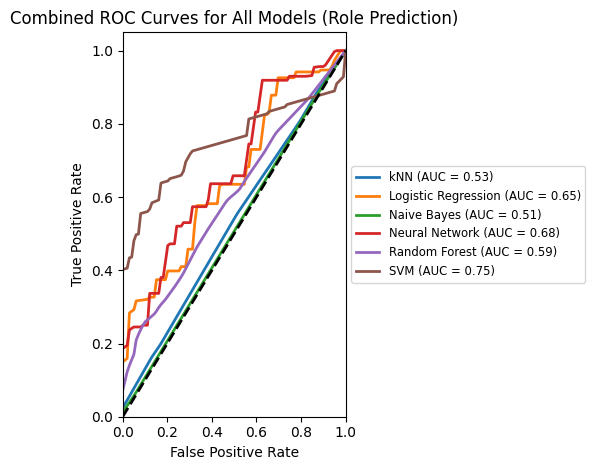

In [ ]:
# Example usage:
plot_combined_roc(role_models, X_role_test, Y_role_test, "Role Prediction", role_class_labels)
# plot_generalized_roc(company_models, X_company_test, Y_company_test, "Company Prediction", company_class_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


No positive samples for class Accolite in kNN. Skipping this class.
No positive samples for class BNP Paribas CIB in kNN. Skipping this class.
No positive samples for class Baker Huges in kNN. Skipping this class.
No positive samples for class Baker Hughes in kNN. Skipping this class.
No positive samples for class Buyceps in kNN. Skipping this class.
No positive samples for class Carwale in kNN. Skipping this class.
No positive samples for class Cash Rich in kNN. Skipping this class.
No positive samples for class Clearing corporation of India Limited in kNN. Skipping this class.
No positive samples for class EDS in kNN. Skipping this class.
No positive samples for class EDS(Equity Data Science) in kNN. Skipping this class.
No positive samples for class Equity Data Science  in kNN. Skipping this class.
No positive samples for class Female Cricket in kNN. Skipping this class.
No positive samples for class ICICI  in kNN. Skipping this class.
No positive samples for class IDfy in kNN. Skip

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


No positive samples for class Accolite in Logistic Regression. Skipping this class.
No positive samples for class BNP Paribas CIB in Logistic Regression. Skipping this class.
No positive samples for class Baker Huges in Logistic Regression. Skipping this class.
No positive samples for class Baker Hughes in Logistic Regression. Skipping this class.
No positive samples for class Buyceps in Logistic Regression. Skipping this class.
No positive samples for class Carwale in Logistic Regression. Skipping this class.
No positive samples for class Cash Rich in Logistic Regression. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Logistic Regression. Skipping this class.
No positive samples for class EDS in Logistic Regression. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Logistic Regression. Skipping this class.
No positive samples for class Equity Data Science  in Logistic Regression. Skipping this class.
No positive

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: Us

No positive samples for class KCDH in Random Forest. Skipping this class.
No positive samples for class Nomura  in Random Forest. Skipping this class.
No positive samples for class Prodigy Tech in Random Forest. Skipping this class.
No positive samples for class Quantiphi in Random Forest. Skipping this class.
No positive samples for class Resosoft Services LLP in Random Forest. Skipping this class.
No positive samples for class TransUnion in Random Forest. Skipping this class.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has fe

No positive samples for class Accolite in SVM. Skipping this class.
No positive samples for class BNP Paribas CIB in SVM. Skipping this class.
No positive samples for class Baker Huges in SVM. Skipping this class.
No positive samples for class Baker Hughes in SVM. Skipping this class.
No positive samples for class Buyceps in SVM. Skipping this class.
No positive samples for class Carwale in SVM. Skipping this class.
No positive samples for class Cash Rich in SVM. Skipping this class.
No positive samples for class Clearing corporation of India Limited in SVM. Skipping this class.
No positive samples for class EDS in SVM. Skipping this class.
No positive samples for class EDS(Equity Data Science) in SVM. Skipping this class.
No positive samples for class Equity Data Science  in SVM. Skipping this class.
No positive samples for class Female Cricket in SVM. Skipping this class.
No positive samples for class ICICI  in SVM. Skipping this class.
No positive samples for class IDfy in SVM. Skip

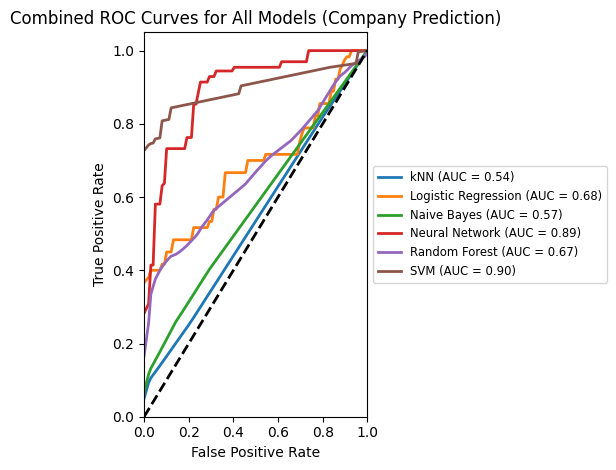

In [ ]:
# Example usage:
# plot_combined_roc(role_models, X_role_test, Y_role_test, "Role Prediction", role_class_labels)
plot_combined_roc(company_models, X_company_test, Y_company_test, "Company Prediction", company_class_labels)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

def plot_precision_recall(models, X_test, Y_test, title, class_labels):
    """
    Function to plot Precision-Recall curves for multiclass classification using One-vs-Rest scheme.
    """
    # Binarize the output (multiclass -> multilabel)
    Y_test_bin = label_binarize(Y_test, classes=range(Y_test.shape[1]))
    n_classes = Y_test.shape[1]

    for model_name, model in models.items():
        plt.figure(figsize=(10, 8))
        if model_name == "Neural Network":  # Handle TensorFlow/Keras models
            try:
                Y_score = model.predict(X_test)
                if Y_score.shape[1] != Y_test.shape[1]:
                    print(f"Mismatch in class count for {model_name}: Y_score={Y_score.shape[1]}, Y_test={Y_test.shape[1]}")
                    Y_score = Y_score[:, :Y_test.shape[1]]  # Adjust class count if necessary
            except Exception as e:
                print(f"Error in Neural Network predictions: {e}")
                continue
        else:  # Handle scikit-learn models
            if hasattr(model, "predict_proba"):
                Y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"):
                Y_score = model.decision_function(X_test)
            else:
                print(f"Model {model_name} does not support probability or decision function, skipping.")
                continue


        # Ensure we don't access non-existent class indexes for the predictions
        min_classes = min(Y_score.shape[1], n_classes)

        if Y_score.shape[1] < n_classes:
            print(f"Model {model_name} predicts {Y_score.shape[1]} classes, but test data has {n_classes} classes. Plotting available classes.")

        # Compute Precision-Recall curve and average precision for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(min_classes):
            if np.sum(Y_test_bin[:, i]) == 0:
                print(f"No positive samples for class {class_labels[i]} in {model_name}. Skipping this class.")
                continue  # Skip if there are no positive samples in the test data for the class

            precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i], Y_score[:, i])
            average_precision[i] = average_precision_score(Y_test_bin[:, i], Y_score[:, i])

        # Plot Precision-Recall curve for each class
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
        for i, color in zip(range(min_classes), colors):
            if i in average_precision:  # Only plot for classes that have average precision calculated
                plt.plot(recall[i], precision[i], color=color, lw=2,
                         label=f'Precision-Recall curve of class {class_labels[i]} (area = {average_precision[i]:0.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f"Precision-Recall Curves for {model_name} ({title})")

        # Shrink the plot and put legend outside
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.85, 1])

        # Display the plot
        plt.show()

# Example usage
role_class_labels = ohe_role.categories_[0]  # Replace with your role class labels
company_class_labels = ohe_company.categories_[0]  # Replace with your company class labels

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Model kNN predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in kNN. Skipping this class.
No positive samples for class Associate Consultant in kNN. Skipping this class.
No positive samples for class Associate Solution Consultant  in kNN. Skipping this class.
No positive samples for class Cloud DevOps Engineer in kNN. Skipping this class.
No positive samples for class Consultant in kNN. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in kNN. Skipping this class.
No positive samples for class Data Analyst  in kNN. Skipping this class.
No positive samples for class Digital technology intern in kNN. Skipping this class.
No positive samples for class Engineer Intern in kNN. Skipping this class.
No positive samples for class Founder's office intern in kNN. Skipping this class.
No positive samples for class Framework Engineer in kNN. Skipping this class.
No positive samples 

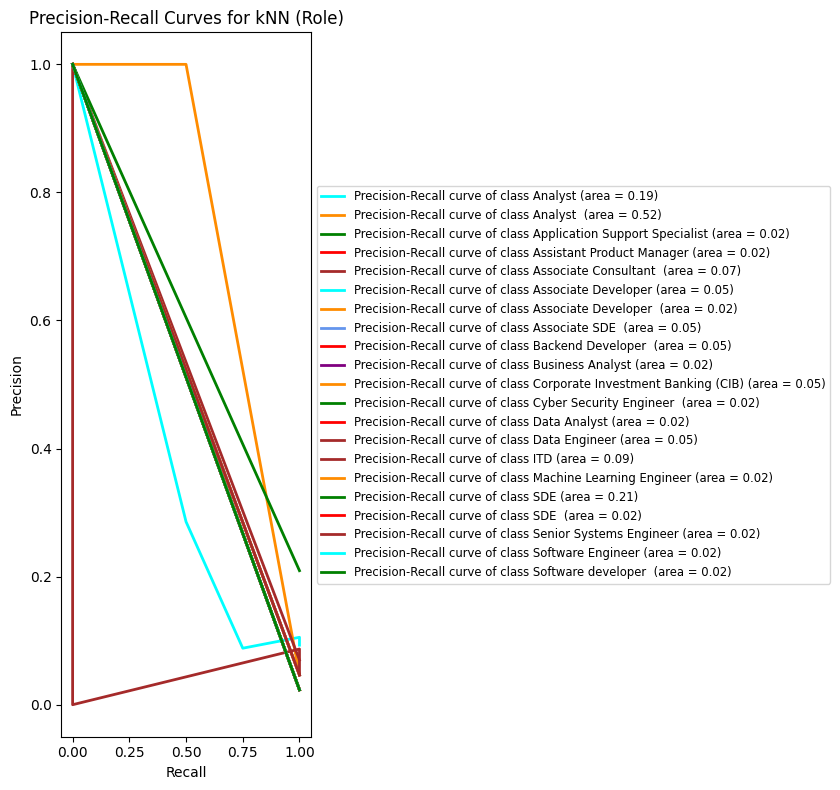

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model Logistic Regression predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Logistic Regression. Skipping this class.
No positive samples for class Associate Consultant in Logistic Regression. Skipping this class.
No positive samples for class Associate Solution Consultant  in Logistic Regression. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Logistic Regression. Skipping this class.
No positive samples for class Consultant in Logistic Regression. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Logistic Regression. Skipping this class.
No positive samples for class Data Analyst  in Logistic Regression. Skipping this class.
No positive samples for class Digital technology intern in Logistic Regression. Skipping this class.
No positive samples for class Engineer Intern in Logistic Regression. Skipping this class.
No positive samples f

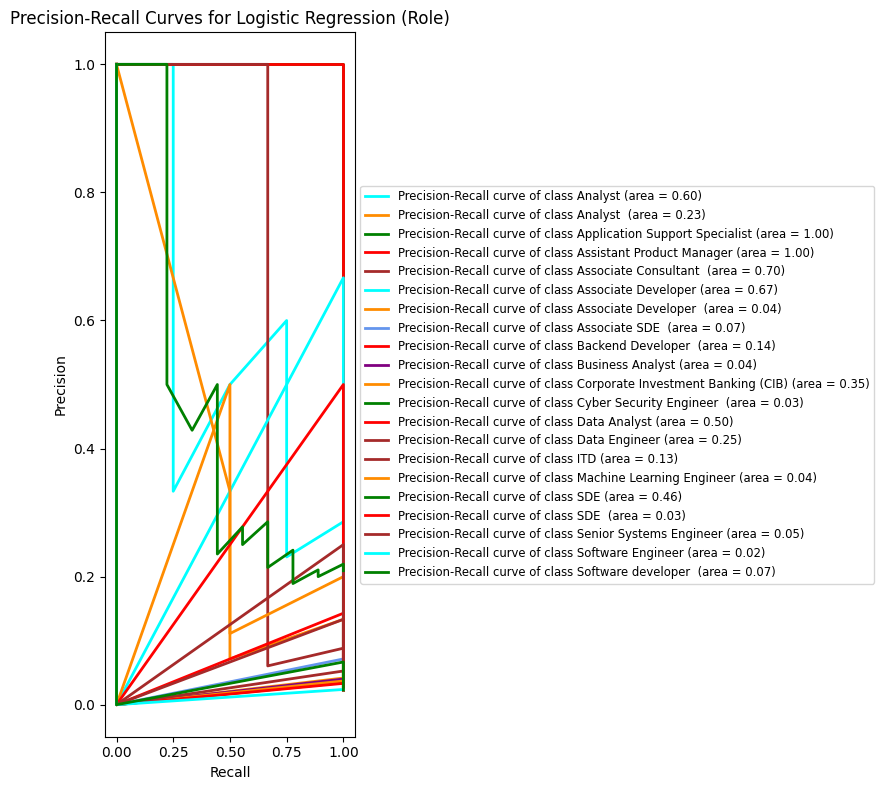

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Model Naive Bayes predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Naive Bayes. Skipping this class.
No positive samples for class Associate Consultant in Naive Bayes. Skipping this class.
No positive samples for class Associate Solution Consultant  in Naive Bayes. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Naive Bayes. Skipping this class.
No positive samples for class Consultant in Naive Bayes. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Naive Bayes. Skipping this class.
No positive samples for class Data Analyst  in Naive Bayes. Skipping this class.
No positive samples for class Digital technology intern in Naive Bayes. Skipping this class.
No positive samples for class Engineer Intern in Naive Bayes. Skipping this class.
No positive samples for class Founder's office intern in Naive Bayes. Skipping this class.
No positiv

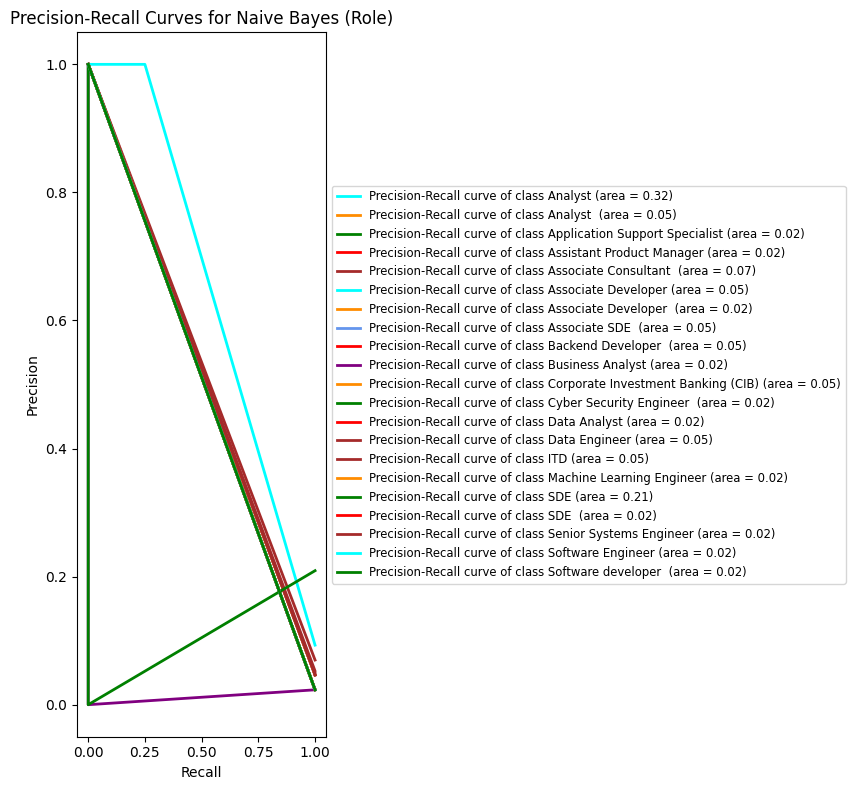

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
No positive samples for class Application Developer in Neural Network. Skipping this class.
No positive samples for class Associate Consultant in Neural Network. Skipping this class.
No positive samples for class Associate Solution Consultant  in Neural Network. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Neural Network. Skipping this class.
No positive samples for class Consultant in Neural Network. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Neural Network. Skipping this class.
No positive samples for class Data Analyst  in Neural Network. Skipping this class.
No positive samples for class Digital technology intern in Neural Network. Skipping this class.
No positive samples for class Engineer Intern in Neural Network. Skipping this class.
No positive samples for class Founder's office intern in Neural Network. Skipping this class.
No positive samples for class Framework

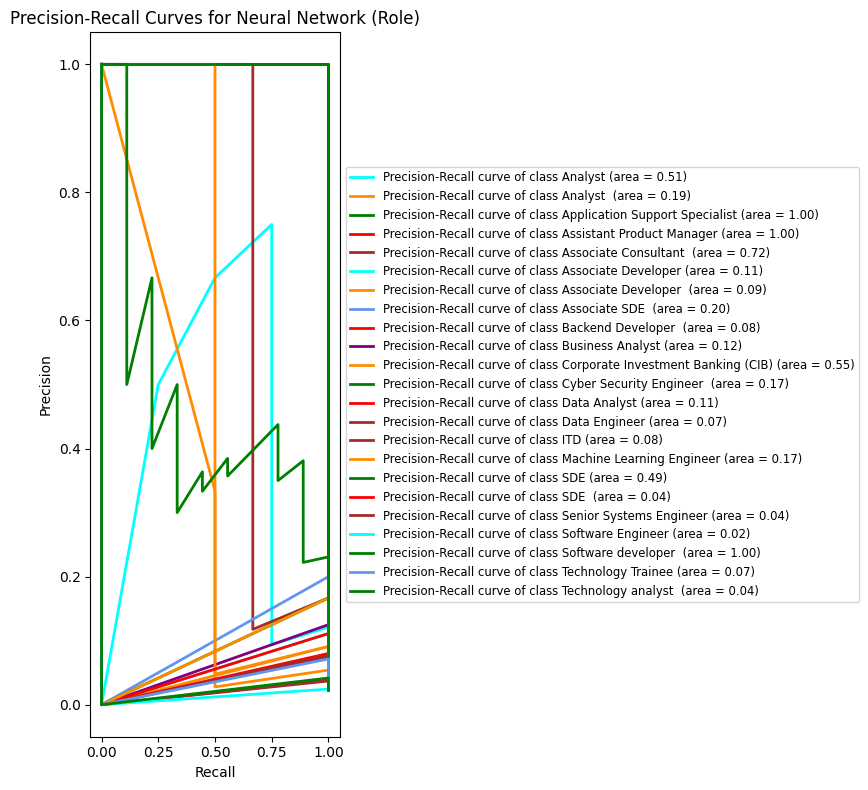

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Model Random Forest predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Random Forest. Skipping this class.
No positive samples for class Associate Consultant in Random Forest. Skipping this class.
No positive samples for class Associate Solution Consultant  in Random Forest. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Random Forest. Skipping this class.
No positive samples for class Consultant in Random Forest. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Random Forest. Skipping this class.
No positive samples for class Data Analyst  in Random Forest. Skipping this class.
No positive samples for class Digital technology intern in Random Forest. Skipping this class.
No positive samples for class Engineer Intern in Random Forest. Skipping this class.
No positive samples for class Founder's office intern in Random Forest. Skipping 

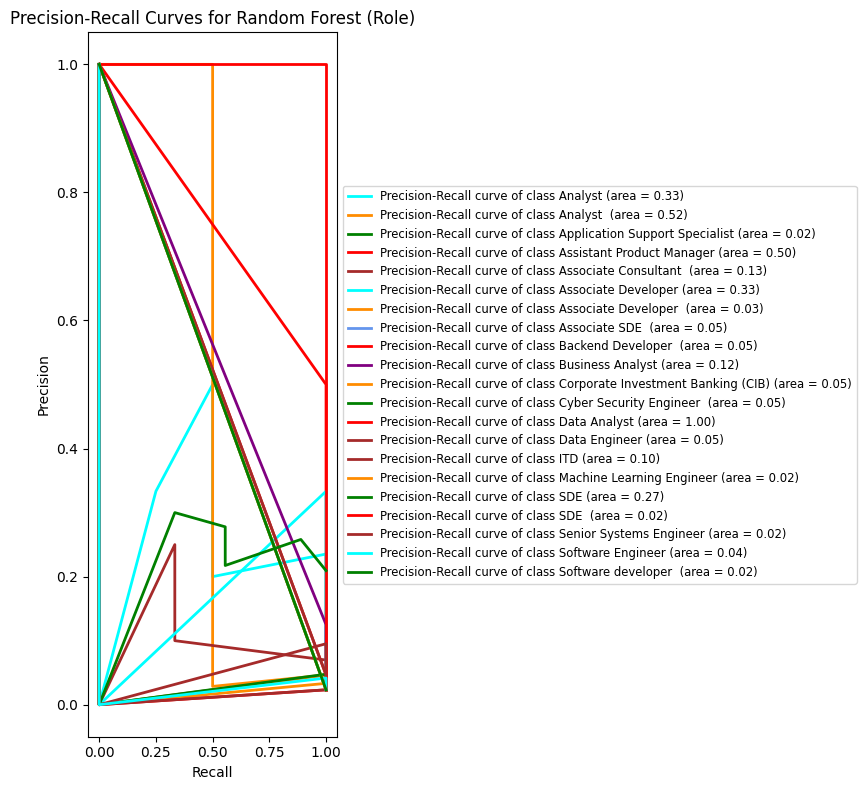

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has fe

No positive samples for class Application Developer in SVM. Skipping this class.
No positive samples for class Associate Consultant in SVM. Skipping this class.
No positive samples for class Associate Solution Consultant  in SVM. Skipping this class.
No positive samples for class Cloud DevOps Engineer in SVM. Skipping this class.
No positive samples for class Consultant in SVM. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in SVM. Skipping this class.
No positive samples for class Data Analyst  in SVM. Skipping this class.
No positive samples for class Digital technology intern in SVM. Skipping this class.
No positive samples for class Engineer Intern in SVM. Skipping this class.
No positive samples for class Founder's office intern in SVM. Skipping this class.
No positive samples for class Framework Engineer in SVM. Skipping this class.
No positive samples for class Full Stack Intern in SVM. Skipping this class.
No positive samples for class HR

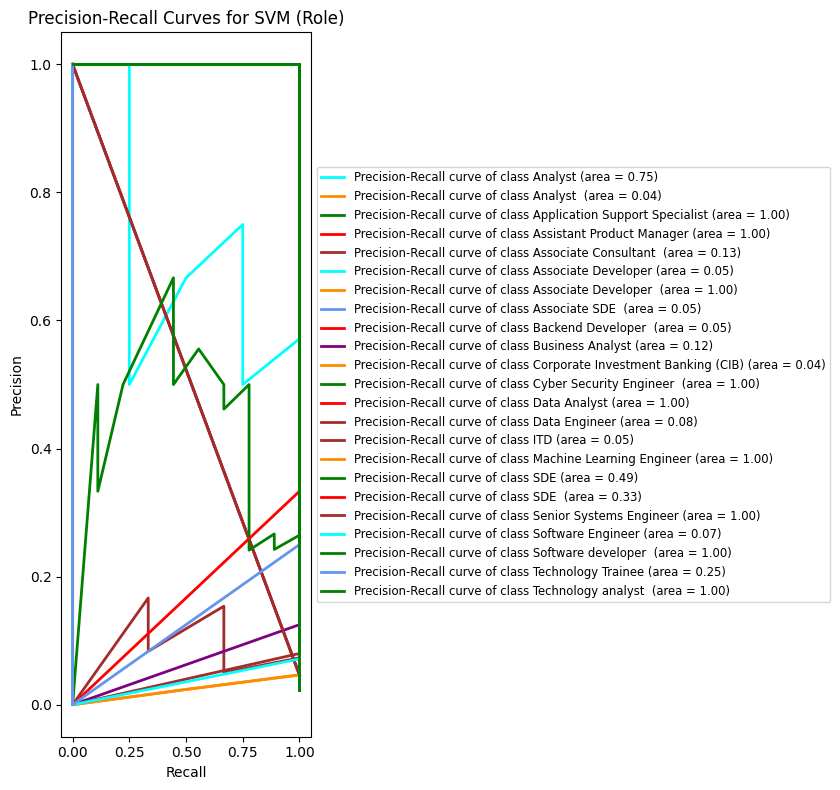

In [ ]:
# Plot Precision-Recall curves for role models
plot_precision_recall(role_models, X_role_test, Y_role_test, 'Role', role_class_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Model kNN predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in kNN. Skipping this class.
No positive samples for class BNP Paribas CIB in kNN. Skipping this class.
No positive samples for class Baker Huges in kNN. Skipping this class.
No positive samples for class Baker Hughes in kNN. Skipping this class.
No positive samples for class Buyceps in kNN. Skipping this class.
No positive samples for class Carwale in kNN. Skipping this class.
No positive samples for class Cash Rich in kNN. Skipping this class.
No positive samples for class Clearing corporation of India Limited in kNN. Skipping this class.
No positive samples for class EDS in kNN. Skipping this class.
No positive samples for class EDS(Equity Data Science) in kNN. Skipping this class.
No positive samples for class Equity Data Science  in kNN. Skipping this class.
No positive samples for class Female Cricket in kNN. Skipping this class.
No positive samples for 

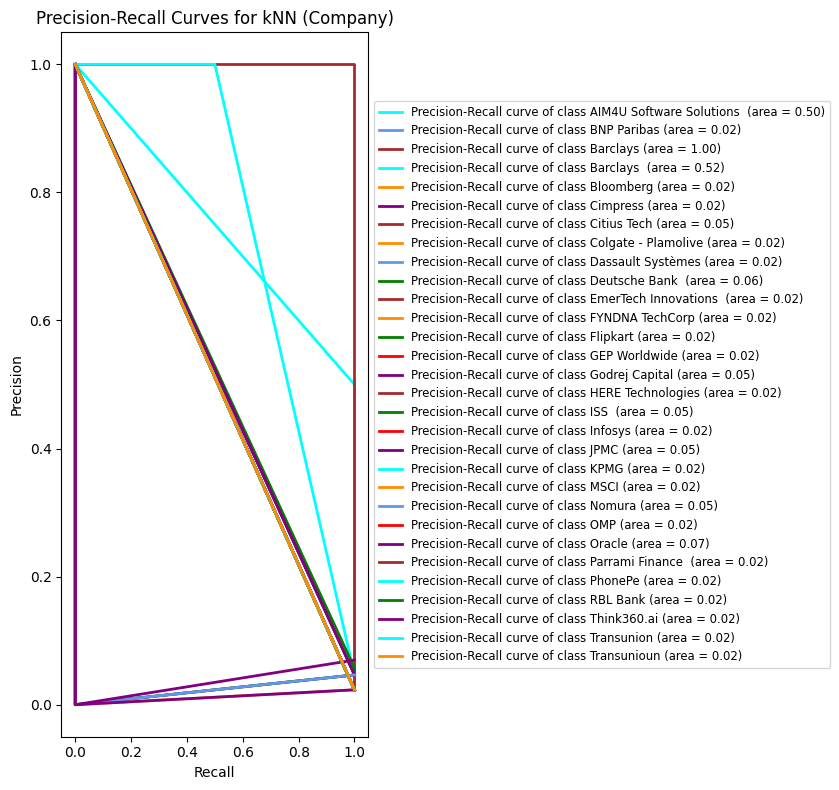

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model Logistic Regression predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Logistic Regression. Skipping this class.
No positive samples for class BNP Paribas CIB in Logistic Regression. Skipping this class.
No positive samples for class Baker Huges in Logistic Regression. Skipping this class.
No positive samples for class Baker Hughes in Logistic Regression. Skipping this class.
No positive samples for class Buyceps in Logistic Regression. Skipping this class.
No positive samples for class Carwale in Logistic Regression. Skipping this class.
No positive samples for class Cash Rich in Logistic Regression. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Logistic Regression. Skipping this class.
No positive samples for class EDS in Logistic Regression. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Logistic Regression. Skipping this class.
No

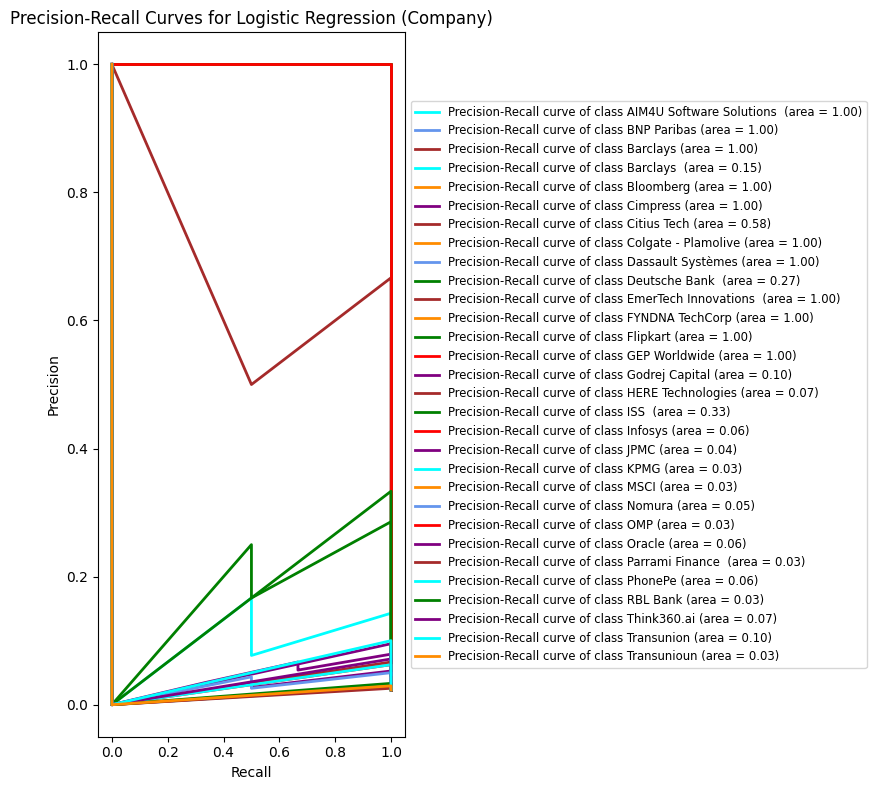

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Model Naive Bayes predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Naive Bayes. Skipping this class.
No positive samples for class BNP Paribas CIB in Naive Bayes. Skipping this class.
No positive samples for class Baker Huges in Naive Bayes. Skipping this class.
No positive samples for class Baker Hughes in Naive Bayes. Skipping this class.
No positive samples for class Buyceps in Naive Bayes. Skipping this class.
No positive samples for class Carwale in Naive Bayes. Skipping this class.
No positive samples for class Cash Rich in Naive Bayes. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Naive Bayes. Skipping this class.
No positive samples for class EDS in Naive Bayes. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Naive Bayes. Skipping this class.
No positive samples for class Equity Data Science  in Naive Bayes. Skipping this class.
No

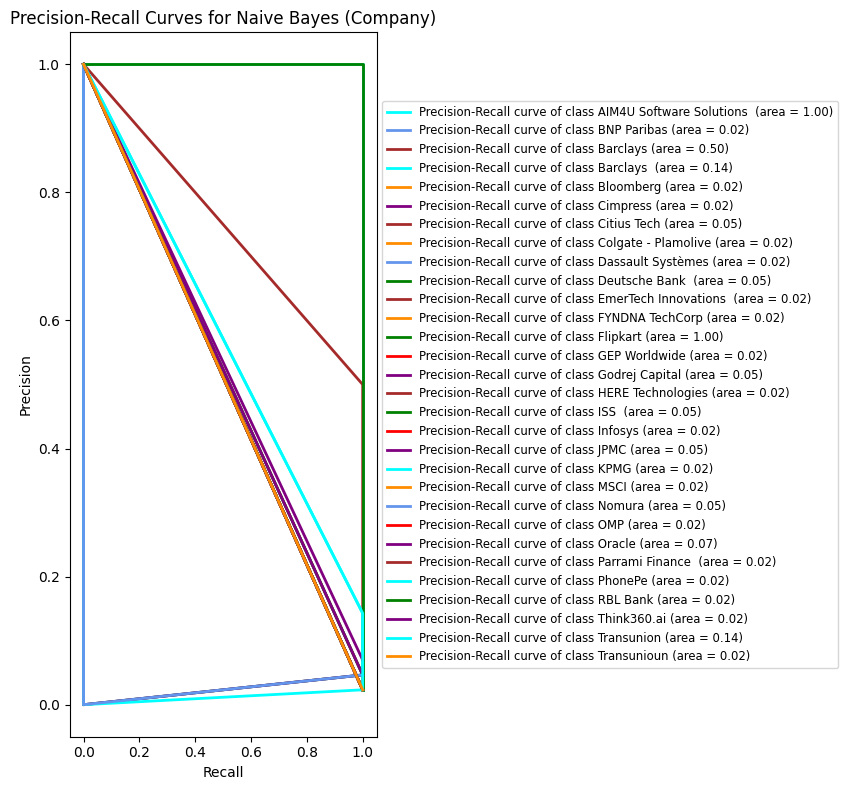

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
No positive samples for class Accolite in Neural Network. Skipping this class.
No positive samples for class BNP Paribas CIB in Neural Network. Skipping this class.
No positive samples for class Baker Huges in Neural Network. Skipping this class.
No positive samples for class Baker Hughes in Neural Network. Skipping this class.
No positive samples for class Buyceps in Neural Network. Skipping this class.
No positive samples for class Carwale in Neural Network. Skipping this class.
No positive samples for class Cash Rich in Neural Network. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Neural Network. Skipping this class.
No positive samples for class EDS in Neural Network. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Neural Network. Skipping this class.
No positive samples for class Equity Data Science  in Neural Network. Skipping this class.
No positive samples for clas

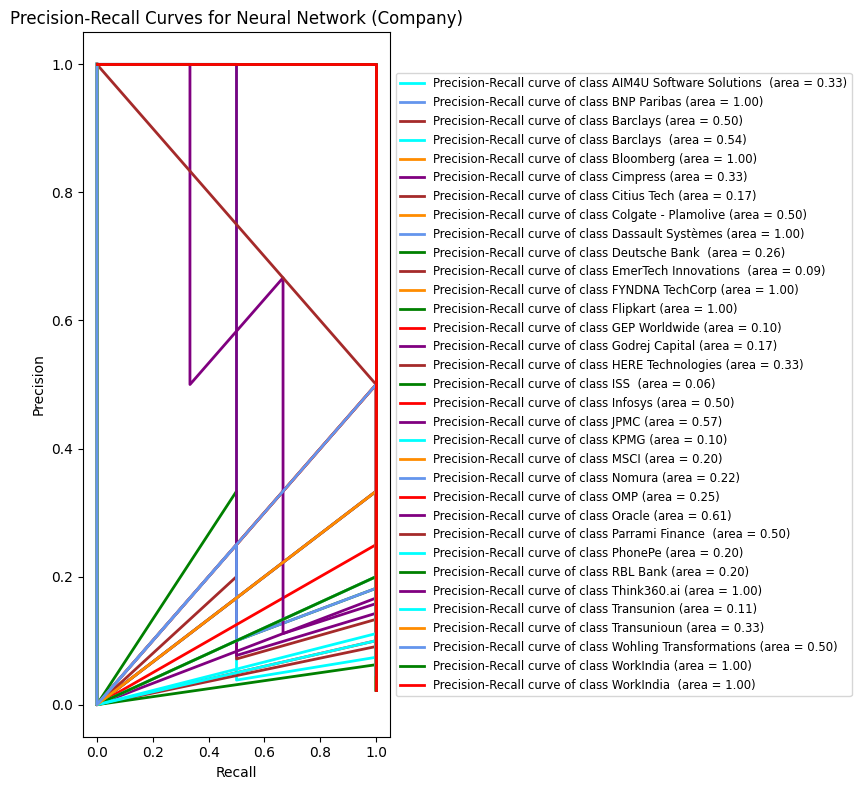

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Model Random Forest predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Random Forest. Skipping this class.
No positive samples for class BNP Paribas CIB in Random Forest. Skipping this class.
No positive samples for class Baker Huges in Random Forest. Skipping this class.
No positive samples for class Baker Hughes in Random Forest. Skipping this class.
No positive samples for class Buyceps in Random Forest. Skipping this class.
No positive samples for class Carwale in Random Forest. Skipping this class.
No positive samples for class Cash Rich in Random Forest. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Random Forest. Skipping this class.
No positive samples for class EDS in Random Forest. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Random Forest. Skipping this class.
No positive samples for class Equity Data Science  in Random Forest.

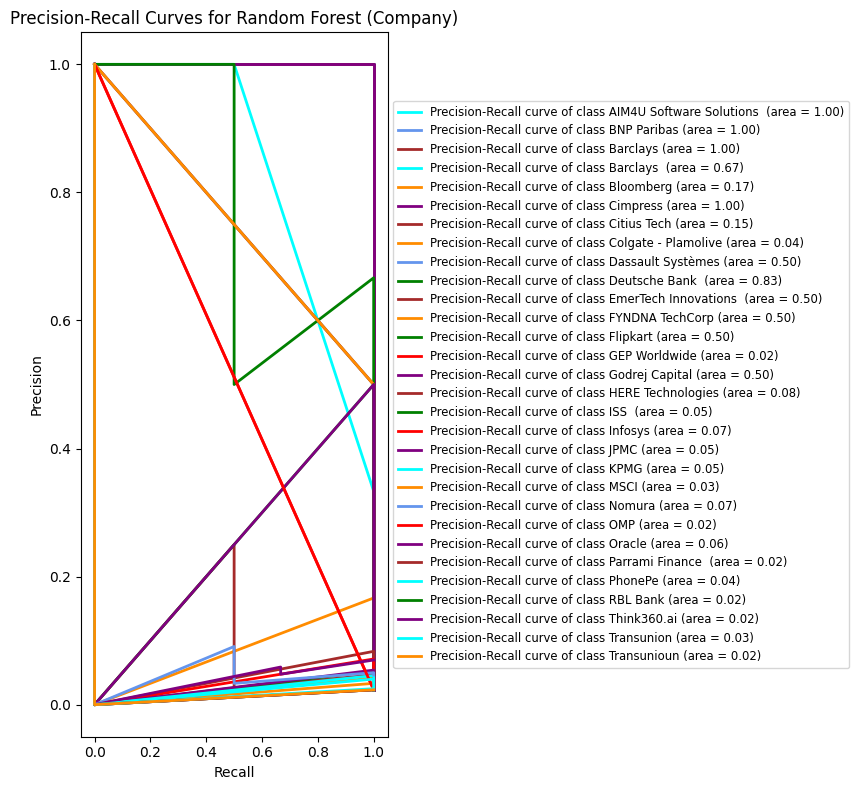

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has fe

No positive samples for class Accolite in SVM. Skipping this class.
No positive samples for class BNP Paribas CIB in SVM. Skipping this class.
No positive samples for class Baker Huges in SVM. Skipping this class.
No positive samples for class Baker Hughes in SVM. Skipping this class.
No positive samples for class Buyceps in SVM. Skipping this class.
No positive samples for class Carwale in SVM. Skipping this class.
No positive samples for class Cash Rich in SVM. Skipping this class.
No positive samples for class Clearing corporation of India Limited in SVM. Skipping this class.
No positive samples for class EDS in SVM. Skipping this class.
No positive samples for class EDS(Equity Data Science) in SVM. Skipping this class.
No positive samples for class Equity Data Science  in SVM. Skipping this class.
No positive samples for class Female Cricket in SVM. Skipping this class.
No positive samples for class ICICI  in SVM. Skipping this class.
No positive samples for class IDfy in SVM. Skip

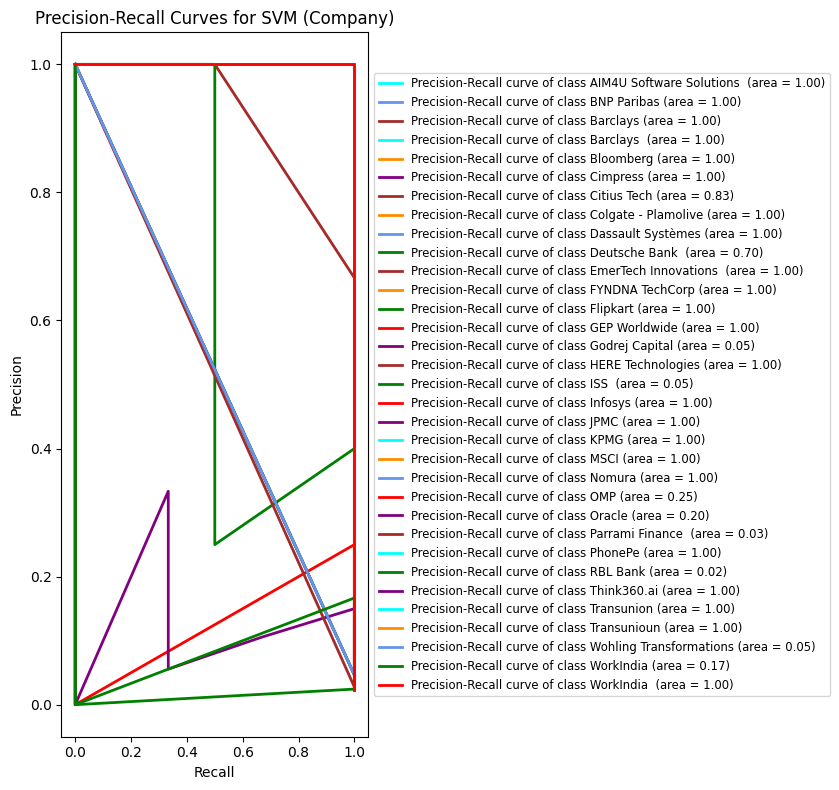

In [ ]:
# Plot Precision-Recall curves for company models
plot_precision_recall(company_models, X_company_test, Y_company_test, 'Company', company_class_labels)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_precision_recall(models, X_test, Y_test, title, class_labels):
    """
    Function to plot combined Precision-Recall curves for all models on a single plot.
    Handles class mismatch between model predictions and test data, and ensures consistent sample sizes.
    """
    # Binarize the output (multiclass -> multilabel)
    Y_test_bin = label_binarize(Y_test, classes=range(Y_test.shape[1]))
    n_classes = Y_test.shape[1]

    # Initialize dictionary to store AUC for each model
    model_avg_precision = {}

    # Initialize a list for storing the precision-recall curves
    precision_all = []
    recall_all = []

    for model_name, model in models.items():
        if model_name == "Neural Network":  # Handle TensorFlow/Keras models
            try:
                Y_score = model.predict(X_test)
                if Y_score.shape[1] != Y_test.shape[1]:
                    print(f"Mismatch in class count for {model_name}: Y_score={Y_score.shape[1]}, Y_test={Y_test.shape[1]}")
                    Y_score = Y_score[:, :Y_test.shape[1]]  # Adjust class count if necessary
            except Exception as e:
                print(f"Error in Neural Network predictions: {e}")
                continue
        else:  # Handle scikit-learn models
            if hasattr(model, "predict_proba"):
                Y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"):
                Y_score = model.decision_function(X_test)
            else:
                print(f"Model {model_name} does not support probability or decision function, skipping.")
                continue

        # Ensure we don't access non-existent class indexes for the predictions
        min_classes = min(Y_score.shape[1], n_classes)

        if Y_score.shape[1] < n_classes:
            print(f"Model {model_name} predicts {Y_score.shape[1]} classes, but test data has {n_classes} classes. Plotting available classes.")

        # Initialize lists to store precision and recall values for each class
        precision_per_model = []
        recall_per_model = []

        # Compute Precision-Recall curve and average precision for each class
        for i in range(min_classes):
            if np.sum(Y_test_bin[:, i]) == 0:
                print(f"No positive samples for class {class_labels[i]} in {model_name}. Skipping this class.")
                continue  # Skip if there are no positive samples in the test data for the class

            precision, recall, _ = precision_recall_curve(Y_test_bin[:, i], Y_score[:, i])

            # Interpolate precision-recall to have a consistent recall range
            recall_interp = np.linspace(0, 1, 100)  # Fixed recall values
            precision_interp = np.interp(recall_interp, recall, precision)

            precision_per_model.append(precision_interp)
            recall_per_model.append(recall_interp)

        # Average the precision-recall curves across classes
        mean_precision = np.zeros_like(recall_interp)
        for i in range(len(precision_per_model)):
            mean_precision += precision_per_model[i]

        mean_precision /= len(precision_per_model)

        # Compute average precision for the combined Precision-Recall curve
        avg_precision = np.mean([average_precision_score(Y_test_bin[:, i], Y_score[:, i]) for i in range(min_classes)])

        model_avg_precision[model_name] = avg_precision

        # Plot the average Precision-Recall curve for this model
        plt.plot(recall_interp, mean_precision, lw=2, label=f'{model_name} (AP = {avg_precision:0.2f})')

    # Plot settings
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Combined Precision-Recall Curves for All Models ({title})")

    # Add legend and other plot elements
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Display the plot
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found

Model kNN predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in kNN. Skipping this class.
No positive samples for class Associate Consultant in kNN. Skipping this class.
No positive samples for class Associate Solution Consultant  in kNN. Skipping this class.
No positive samples for class Cloud DevOps Engineer in kNN. Skipping this class.
No positive samples for class Consultant in kNN. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in kNN. Skipping this class.
No positive samples for class Data Analyst  in kNN. Skipping this class.
No positive samples for class Digital technology intern in kNN. Skipping this class.
No positive samples for class Engineer Intern in kNN. Skipping this class.
No positive samples for class Founder's office intern in kNN. Skipping this class.
No positive samples for class Framework Engineer in kNN. Skipping this class.
No positive samples 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

No positive samples for class Associate Consultant in Logistic Regression. Skipping this class.
No positive samples for class Associate Solution Consultant  in Logistic Regression. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Logistic Regression. Skipping this class.
No positive samples for class Consultant in Logistic Regression. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Logistic Regression. Skipping this class.
No positive samples for class Data Analyst  in Logistic Regression. Skipping this class.
No positive samples for class Digital technology intern in Logistic Regression. Skipping this class.
No positive samples for class Engineer Intern in Logistic Regression. Skipping this class.
No positive samples for class Founder's office intern in Logistic Regression. Skipping this class.
No positive samples for class Framework Engineer in Logistic Regression. Skipping this class.
No positive samples for class 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
No positive samples for class Application Developer in Neural Network. Skipping this class.
No positive samples for class Associate Consultant in Neural Network. Skipping this class.
No positive samples for class Associate Solution Consultant  in Neural Network. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Neural Network. Skipping this class.
No positive samples for class Consultant in Neural Network. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Neural Network. Skipping this class.
No positive samples for class Data Analyst  in Neural Network. Skipping this class.
No positive samples for class Digital technology intern in Neural Network. Skipping this class.
No positive samples for class Engineer Intern in Neural Network. Skipping this class.
No positive samples for class Founder's office intern in Neural Network. Skipping this class.
No positive samples for class Framework

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

Model Random Forest predicts 42 classes, but test data has 46 classes. Plotting available classes.
No positive samples for class Application Developer in Random Forest. Skipping this class.
No positive samples for class Associate Consultant in Random Forest. Skipping this class.
No positive samples for class Associate Solution Consultant  in Random Forest. Skipping this class.
No positive samples for class Cloud DevOps Engineer in Random Forest. Skipping this class.
No positive samples for class Consultant in Random Forest. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in Random Forest. Skipping this class.
No positive samples for class Data Analyst  in Random Forest. Skipping this class.
No positive samples for class Digital technology intern in Random Forest. Skipping this class.
No positive samples for class Engineer Intern in Random Forest. Skipping this class.
No positive samples for class Founder's office intern in Random Forest. Skipping 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

No positive samples for class Application Developer in SVM. Skipping this class.
No positive samples for class Associate Consultant in SVM. Skipping this class.
No positive samples for class Associate Solution Consultant  in SVM. Skipping this class.
No positive samples for class Cloud DevOps Engineer in SVM. Skipping this class.
No positive samples for class Consultant in SVM. Skipping this class.
No positive samples for class Corporate Investment Banking Intern in SVM. Skipping this class.
No positive samples for class Data Analyst  in SVM. Skipping this class.
No positive samples for class Digital technology intern in SVM. Skipping this class.
No positive samples for class Engineer Intern in SVM. Skipping this class.
No positive samples for class Founder's office intern in SVM. Skipping this class.
No positive samples for class Framework Engineer in SVM. Skipping this class.
No positive samples for class Full Stack Intern in SVM. Skipping this class.
No positive samples for class HR

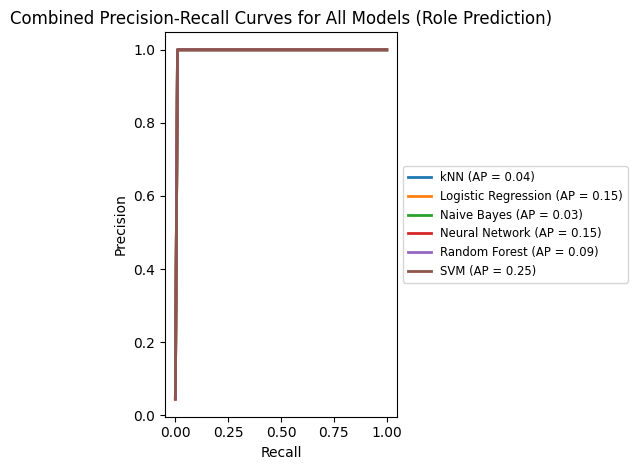

In [ ]:
# Example usage:
plot_combined_precision_recall(role_models, X_role_test, Y_role_test, "Role Prediction", role_class_labels)
# plot_combined_precision_recall(company_models, X_company_test, Y_company_test, "Company Prediction", company_class_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found

Model kNN predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in kNN. Skipping this class.
No positive samples for class BNP Paribas CIB in kNN. Skipping this class.
No positive samples for class Baker Huges in kNN. Skipping this class.
No positive samples for class Baker Hughes in kNN. Skipping this class.
No positive samples for class Buyceps in kNN. Skipping this class.
No positive samples for class Carwale in kNN. Skipping this class.
No positive samples for class Cash Rich in kNN. Skipping this class.
No positive samples for class Clearing corporation of India Limited in kNN. Skipping this class.
No positive samples for class EDS in kNN. Skipping this class.
No positive samples for class EDS(Equity Data Science) in kNN. Skipping this class.
No positive samples for class Equity Data Science  in kNN. Skipping this class.
No positive samples for class Female Cricket in kNN. Skipping this class.
No positive samples for 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

No positive samples for class KCDH in Naive Bayes. Skipping this class.
No positive samples for class Nomura  in Naive Bayes. Skipping this class.
No positive samples for class Prodigy Tech in Naive Bayes. Skipping this class.
No positive samples for class Quantiphi in Naive Bayes. Skipping this class.
No positive samples for class Resosoft Services LLP in Naive Bayes. Skipping this class.
No positive samples for class TransUnion in Naive Bayes. Skipping this class.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
No positive samples for class Accolite in Neural Network. Skipping this class.
No positive samples for class BNP Paribas CIB in Neural Network. Skipping this class.
No positive samples for class Baker Huges in Neural Network. Skipping this class.
No positive samples for class Baker Hughes in Neural Network. Skipping this class.
No positive samples for class Buyceps in Neural Network. Skipping this class.
No positive samples for class Carwale in Neural Network. Skipping this class.
No positive samples for class Cash Rich in Neural Network. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Neural Network. Skipping this class.
No positive samples for class EDS in Neural Network. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Neural Network. Skipping this class.
No positive samples for class Equity Data Science  in Neural Network. Skipping this class.
No positive samples for clas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

Model Random Forest predicts 51 classes, but test data has 54 classes. Plotting available classes.
No positive samples for class Accolite in Random Forest. Skipping this class.
No positive samples for class BNP Paribas CIB in Random Forest. Skipping this class.
No positive samples for class Baker Huges in Random Forest. Skipping this class.
No positive samples for class Baker Hughes in Random Forest. Skipping this class.
No positive samples for class Buyceps in Random Forest. Skipping this class.
No positive samples for class Carwale in Random Forest. Skipping this class.
No positive samples for class Cash Rich in Random Forest. Skipping this class.
No positive samples for class Clearing corporation of India Limited in Random Forest. Skipping this class.
No positive samples for class EDS in Random Forest. Skipping this class.
No positive samples for class EDS(Equity Data Science) in Random Forest. Skipping this class.
No positive samples for class Equity Data Science  in Random Forest.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

No positive samples for class Accolite in SVM. Skipping this class.
No positive samples for class BNP Paribas CIB in SVM. Skipping this class.
No positive samples for class Baker Huges in SVM. Skipping this class.
No positive samples for class Baker Hughes in SVM. Skipping this class.
No positive samples for class Buyceps in SVM. Skipping this class.
No positive samples for class Carwale in SVM. Skipping this class.
No positive samples for class Cash Rich in SVM. Skipping this class.
No positive samples for class Clearing corporation of India Limited in SVM. Skipping this class.
No positive samples for class EDS in SVM. Skipping this class.
No positive samples for class EDS(Equity Data Science) in SVM. Skipping this class.
No positive samples for class Equity Data Science  in SVM. Skipping this class.
No positive samples for class Female Cricket in SVM. Skipping this class.
No positive samples for class ICICI  in SVM. Skipping this class.
No positive samples for class IDfy in SVM. Skip

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

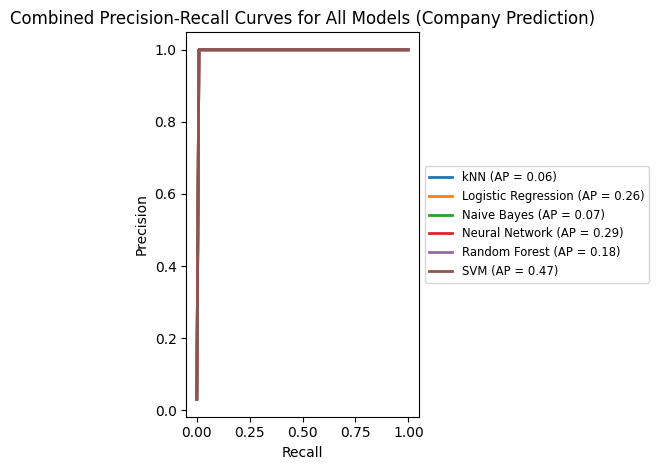

In [ ]:
# Example usage:
# plot_combined_precision_recall(role_models, X_role_test, Y_role_test, "Role Prediction", role_class_labels)
plot_combined_precision_recall(company_models, X_company_test, Y_company_test, "Company Prediction", company_class_labels)

In [ ]:
# Feature Importance using SHAP for explainable models
def plot_feature_importance_shap(model, X_train, model_type):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

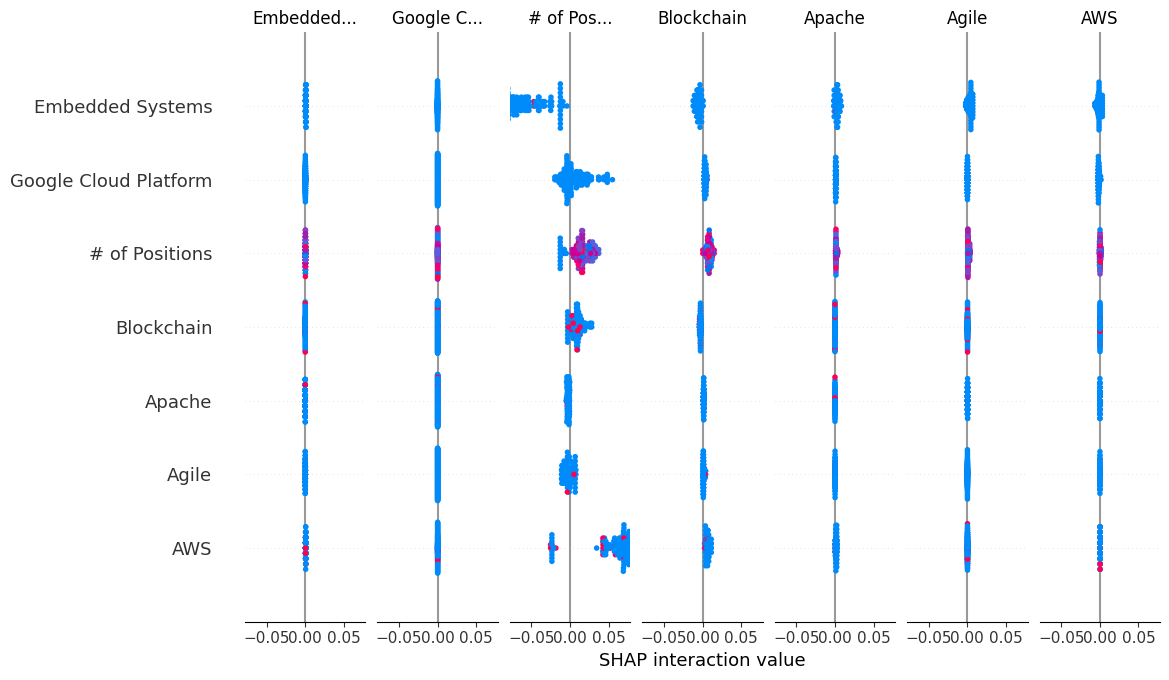

In [ ]:
# Example for Random Forest feature importance (use LIME for non-tree models)
plot_feature_importance_shap(role_models['Random Forest'], X_role_train, 'Role')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(models, X_test, Y_test, title, class_labels):
    """
    Function to plot confusion matrices for multiclass classification.
    """
    # Convert one-hot encoded Y_test back to class labels
    if Y_test.ndim > 1:  # If Y_test is one-hot encoded
        Y_test = np.argmax(Y_test, axis=1)

    # Loop through each model and plot its confusion matrix
    for model_name, model in models.items():
        plt.figure(figsize=(8, 6))

        # Predict the labels for the test set
        if hasattr(model, "predict"):
            Y_pred = model.predict(X_test)
        else:
            print(f"Model {model_name} does not support predict, skipping.")
            continue

        # Convert predictions to class labels if they are one-hot encoded
        if Y_pred.ndim > 1:
            Y_pred = np.argmax(Y_pred, axis=1)

        # Compute the confusion matrix
        cm = confusion_matrix(Y_test, Y_pred)

        # Plot confusion matrix using seaborn heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f"Confusion Matrix for {model_name} ({title})")

        # Display the plot
        plt.tight_layout()
        plt.show()

# Example usage
role_class_labels = ohe_role.categories_[0]  # Replace with your role class labels
company_class_labels = ohe_company.categories_[0]  # Replace with your company class labels

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


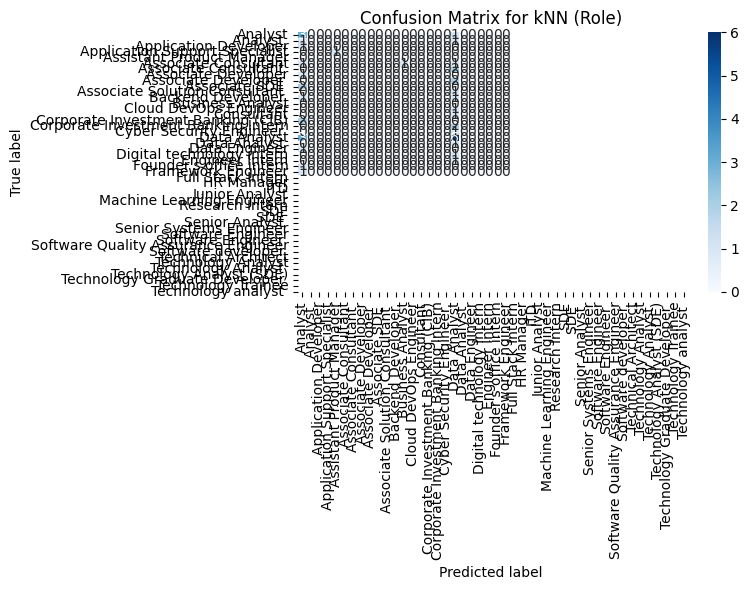

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


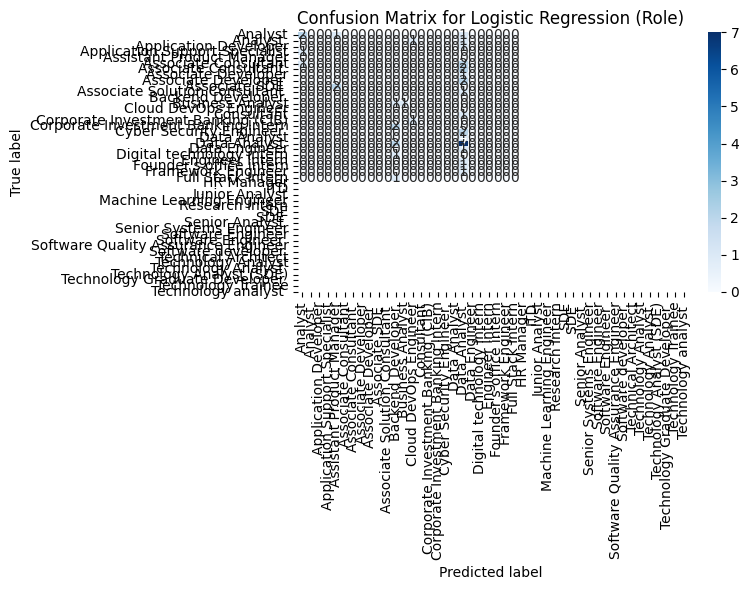

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


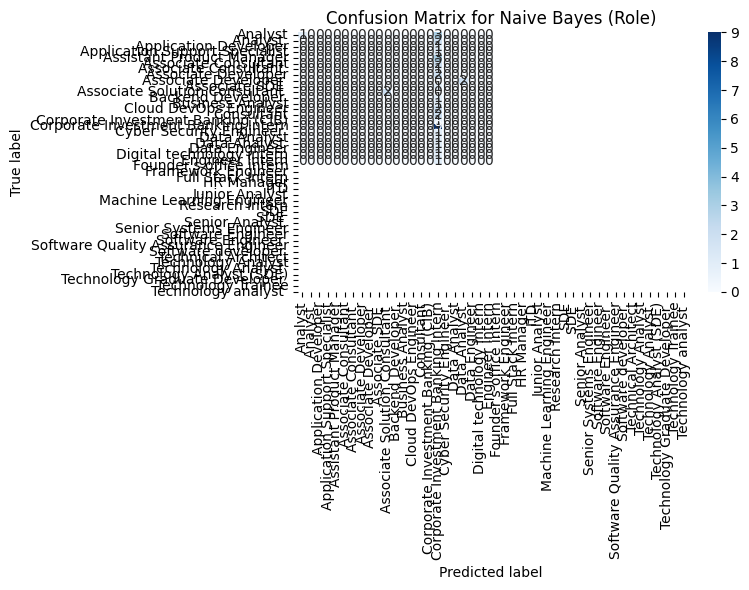

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


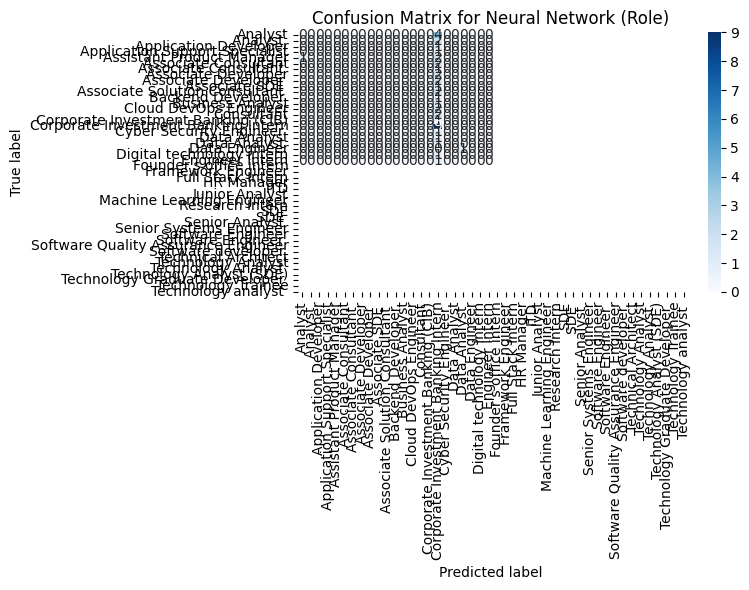

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Mix of label input types (string and number)

<Figure size 800x600 with 0 Axes>

In [ ]:
plot_confusion_matrix(role_models, X_role_test, Y_role_test, 'Role', role_class_labels)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Matrix for Role and Company Predictions
def plot_correlation_matrix(df, model_type):
    """
    Plots the correlation matrix for the given dataframe.

    Parameters:
    df (DataFrame): DataFrame containing the features to analyze.
    model_type (str): Type of model ('Role' or 'Company') for the plot title.
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 10))

    # Use a heatmap without annotations for better readability
    sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, square=True, linewidths=0.5,
                linecolor='black', annot=False)

    # Shorten the title
    plt.title(f'Correlation Matrix: {model_type}', fontsize=16)

    plt.tight_layout()
    plt.show()

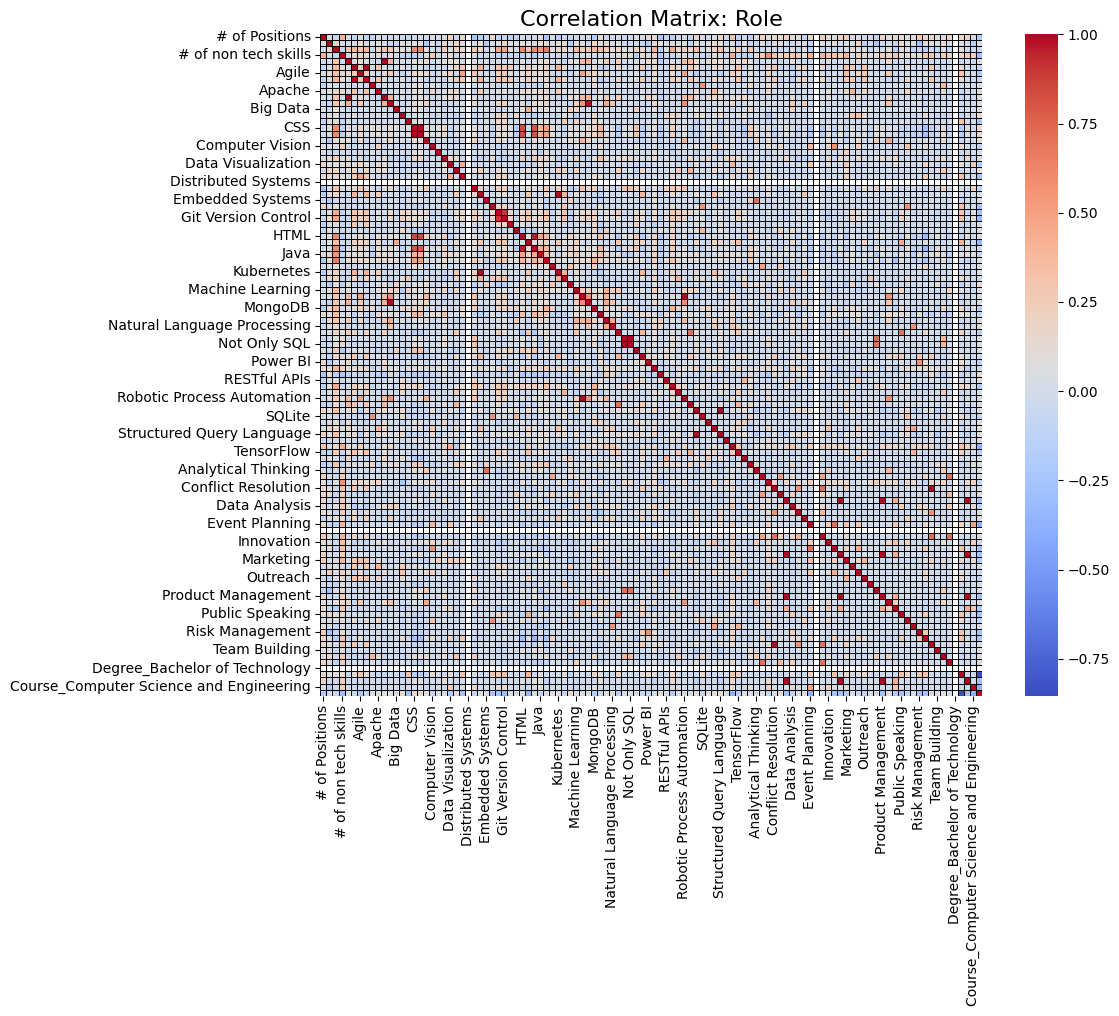

In [ ]:
plot_correlation_matrix(X_role, 'Role')

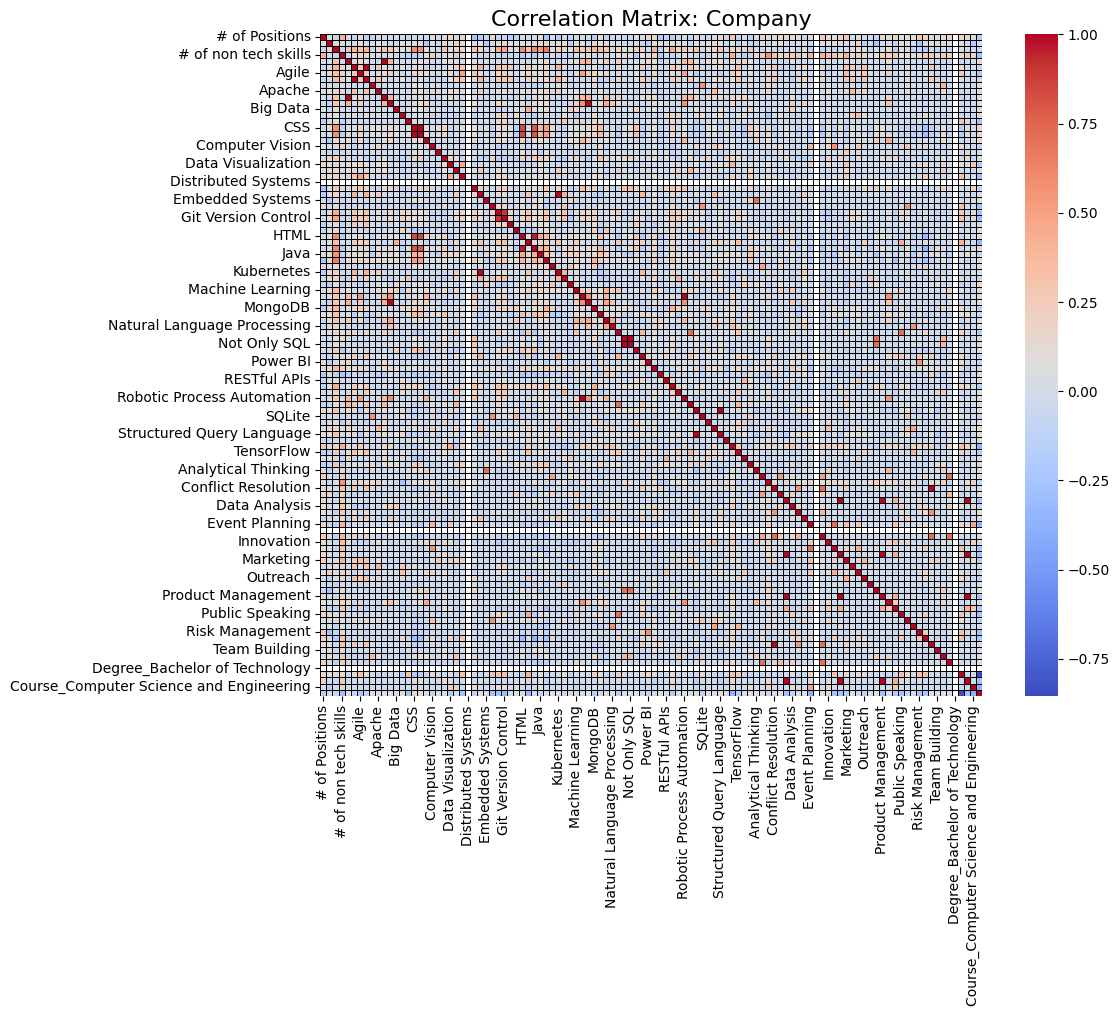

In [ ]:
plot_correlation_matrix(X_company, 'Company')

In [ ]:
from sklearn.metrics import mean_absolute_error, f1_score, log_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

from sklearn.metrics import f1_score, mean_absolute_error, log_loss, cohen_kappa_score

def compare_metrics(models, X_test, Y_test, model_type):
    metrics = {}

    # Convert one-hot encoded Y_test back to class labels
    if Y_test.ndim > 1:  # If Y_test is one-hot encoded
        Y_test_class = np.argmax(Y_test, axis=1)
    else:
        Y_test_class = Y_test  # Already in integer format

    # Get the unique classes from Y_test_class
    unique_classes = np.unique(Y_test_class)

    for model_name, model in models.items():
        if model_name == 'Neural Network':
            Y_pred = model.predict(X_test)
            Y_pred_class = np.argmax(Y_pred, axis=1)
        else:
            Y_pred_class = model.predict(X_test)

            # Ensure predictions are in integer format if one-hot
            if len(Y_pred_class.shape) > 1:
                Y_pred_class = np.argmax(Y_pred_class, axis=1)

        # Store the predictions
        metrics[model_name] = {
            'Accuracy': accuracy_score(Y_test_class, Y_pred_class),
            'F1 Score': f1_score(Y_test_class, Y_pred_class, average='weighted'),
            'Mean Absolute Error': mean_absolute_error(Y_test_class, Y_pred_class),
            'Log Loss': log_loss(Y_test_class, model.predict_proba(X_test), labels=unique_classes) if hasattr(model, "predict_proba") else None,
            'Kappa Score': cohen_kappa_score(Y_test_class, Y_pred_class)
        }

    return metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, Y_train, X_test, Y_test):
    # Check if Y_train is not a 1D array (i.e., one-hot encoded)
    if len(Y_train.shape) != 1:
        # Convert one-hot encoded DataFrame or array to a single array of class labels
        Y_train = np.argmax(Y_train.values, axis=1) if hasattr(Y_train, 'values') else np.argmax(Y_train, axis=1)

    # Get learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train,
        Y_train,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    # Calculate mean training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
    plt.plot(train_sizes, test_mean, label='Testing Accuracy', color='orange')
    plt.title(f'Learning Curve for {type(model).__name__}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import learning_curve, StratifiedKFold
import itertools

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, learning_curve
from imblearn.over_sampling import SMOTE

# Function to compute learning curve data, using StratifiedKFold
def plot_learning_curve_single_split(model, X_train, Y_train):
    # Check if Y_train is not a 1D array (i.e., one-hot encoded)
    if len(Y_train.shape) != 1:
        # Convert one-hot encoded DataFrame or array to a single array of class labels
        Y_train = np.argmax(Y_train.values, axis=1) if hasattr(Y_train, 'values') else np.argmax(Y_train, axis=1)

    try:
        # Apply SMOTE to handle class imbalance
        sm = SMOTE(random_state=42)
        X_train_resampled, Y_train_resampled = sm.fit_resample(X_train, Y_train)

        # Define StratifiedKFold with smaller folds if needed
        skf = StratifiedKFold(n_splits=3)

        # Get learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            model,
            X_train_resampled,
            Y_train_resampled,
            cv=skf,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy'
        )

        # Calculate mean training and testing scores
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        return train_sizes, train_mean, test_mean
    except ValueError as e:
        print(f"Skipping model due to error: {e}")
        return None, None, None


# Function to plot combined learning curves for multiple models
def plot_combined_learning_curves_single_split(models, X_train, Y_train):
    # Create a list of unique colors
    colors = itertools.cycle(plt.cm.tab10.colors)  # Use 'tab10' colormap for distinct colors

    # Initialize plot figure
    plt.figure(figsize=(14, 6))

    # Subplot 1: Training curves
    plt.subplot(1, 2, 1)
    for model_name, model in models.items():
        color = next(colors)
        train_sizes, train_mean, _ = plot_learning_curve_single_split(model, X_train, Y_train)
        if train_sizes is not None:
            plt.plot(train_sizes, train_mean, label=f'{model_name} Training', color=color)

    plt.title('Training Learning Curves for All Models')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.grid()

    # Subplot 2: Testing curves
    plt.subplot(1, 2, 2)
    colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle for testing curves
    for model_name, model in models.items():
        color = next(colors)
        train_sizes, _, test_mean = plot_learning_curve_single_split(model, X_train, Y_train)
        if train_sizes is not None:
            plt.plot(train_sizes, test_mean, label=f'{model_name} Testing', color=color)

    plt.title('Testing Learning Curves for All Models')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.grid()

    # Adjust the position of the legend to be outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    # Display both plots
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust to make space for the legend
    plt.show()


In [ ]:
# Compare metrics for role and company models
role_metrics = compare_metrics(role_models, X_role_test, Y_role_test, 'Role')
company_metrics = compare_metrics(company_models, X_company_test, Y_company_test, 'Company')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: [ 0  1  3  4  6  7  8  9 11 12 15 17 18 20 27 29 31 32 34 35 38 44 45]

In [ ]:
#plot_combined_learning_curves_single_split(company_models, X_company_train, Y_company_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


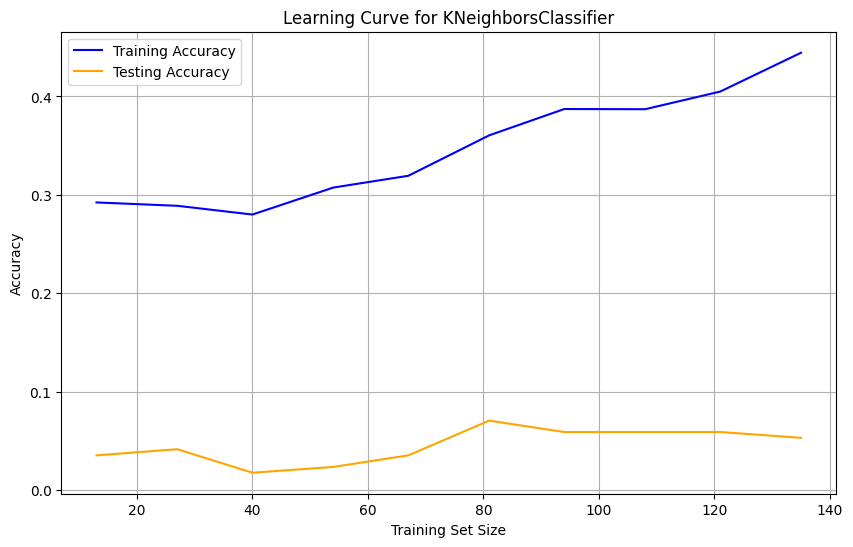

In [ ]:
plot_learning_curve(company_models['kNN'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


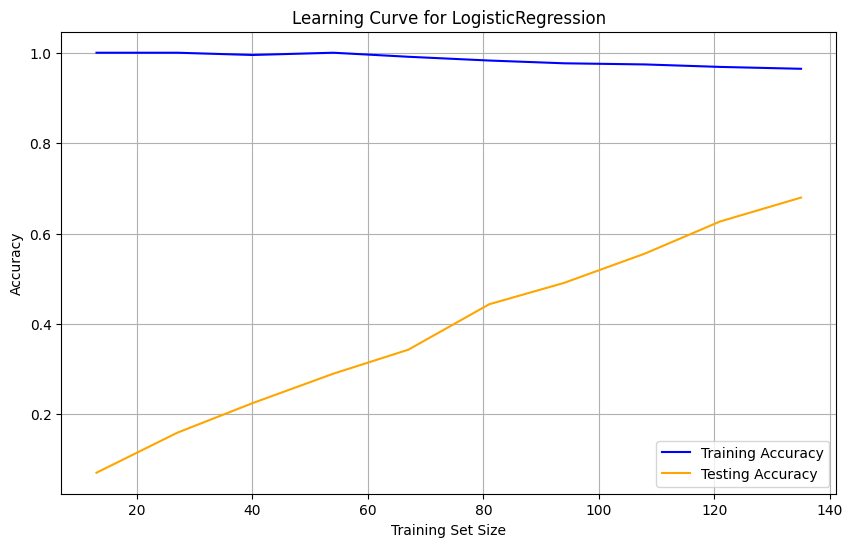

In [ ]:
plot_learning_curve(company_models['Logistic Regression'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


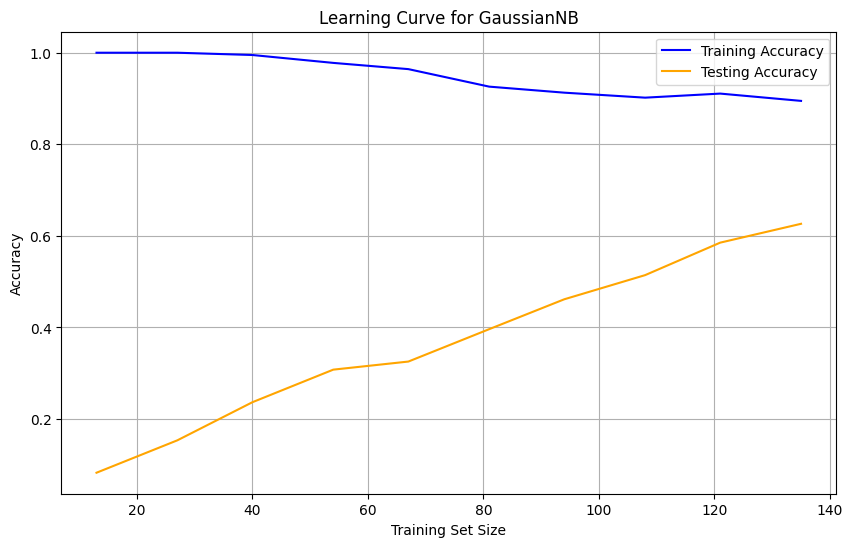

In [ ]:
plot_learning_curve(company_models['Naive Bayes'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


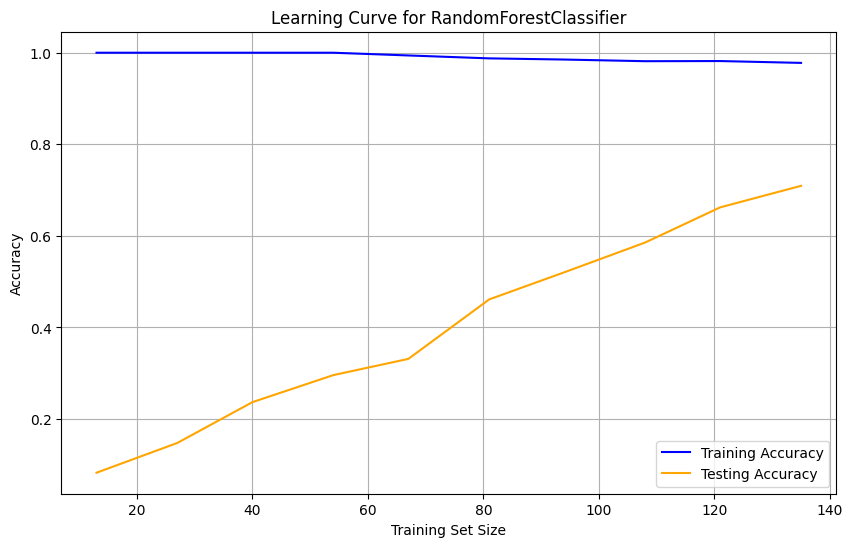

In [ ]:
plot_learning_curve(company_models['Random Forest'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


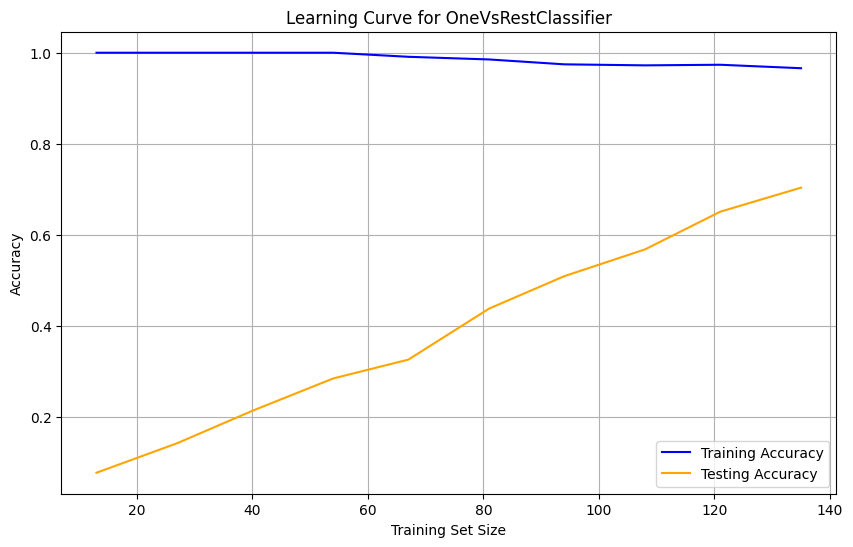

In [ ]:
plot_learning_curve(company_models['SVM'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


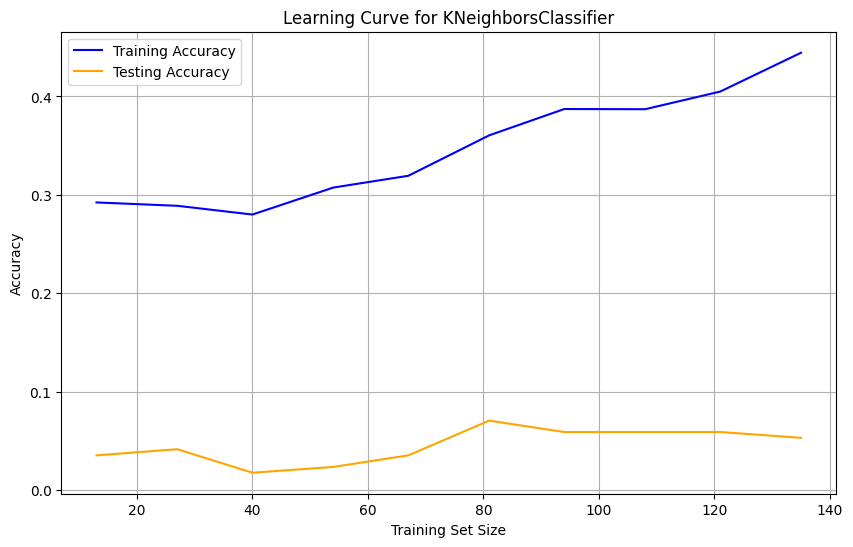

In [ ]:
plot_learning_curve(role_models['kNN'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


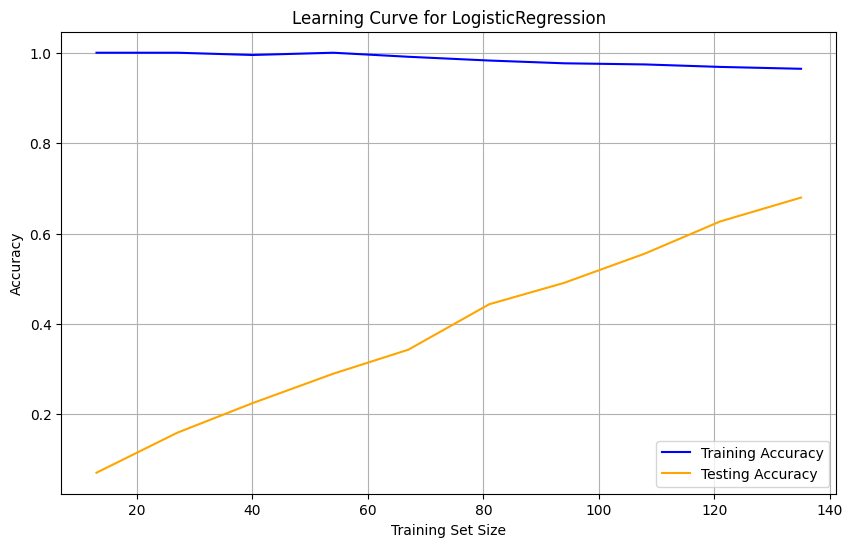

In [ ]:
plot_learning_curve(role_models['Logistic Regression'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


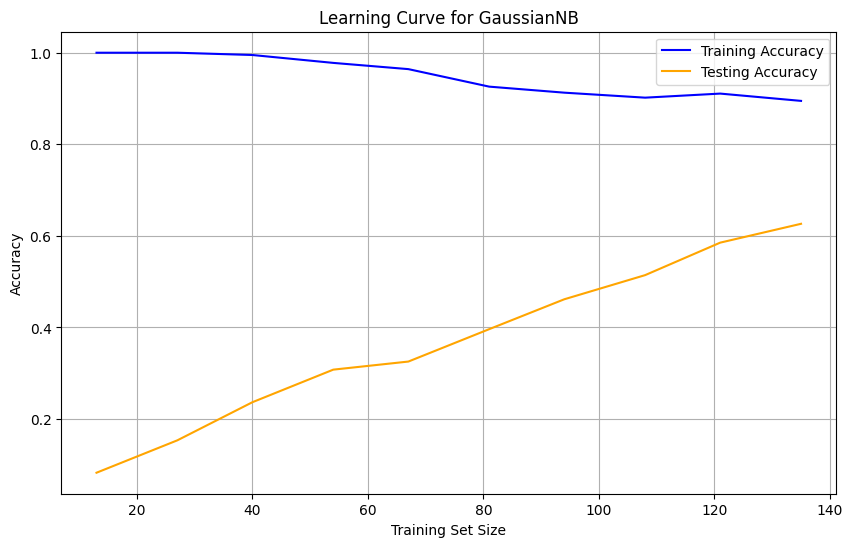

In [ ]:
plot_learning_curve(role_models['Naive Bayes'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


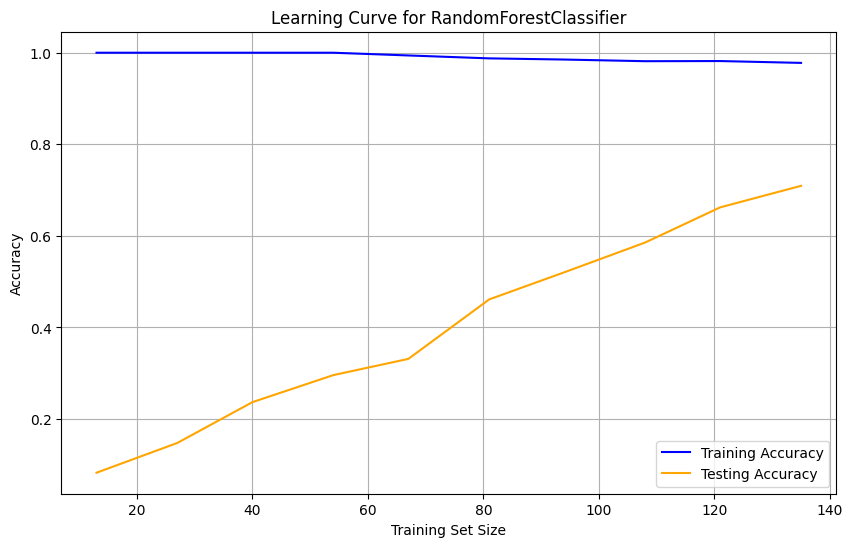

In [ ]:
plot_learning_curve(role_models['Random Forest'], X_company_train, Y_company_train, X_company_test, Y_company_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


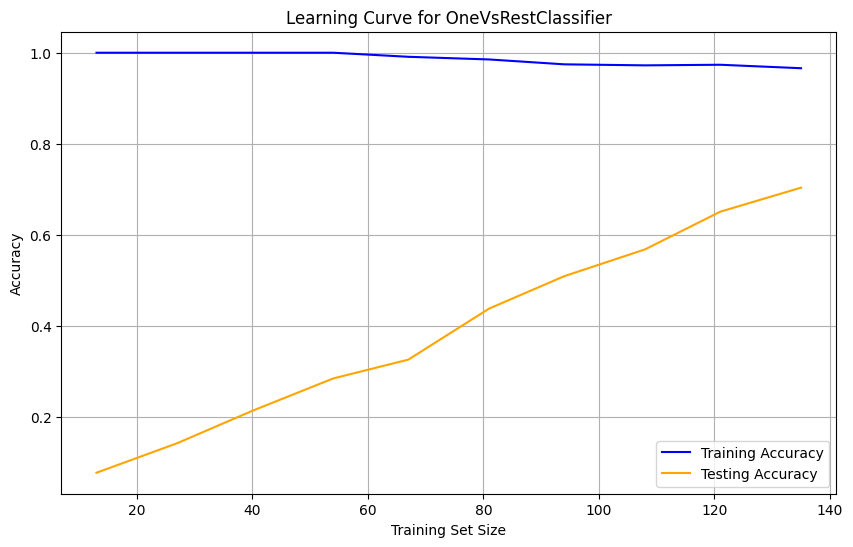

In [ ]:
plot_learning_curve(role_models['SVM'], X_company_train, Y_company_train, X_company_test, Y_company_test)

In [ ]:
from sklearn.calibration import calibration_curve
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_curve(models, X_test, Y_test, title, class_labels):
    """
    Plot calibration curves for multiclass classification for the given models.
    Skips models where mismatches or errors occur.
    """
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        try:
            if model_name == "Neural Network":  # Handle neural networks
                Y_prob = model.predict(X_test)
                if Y_prob.shape[1] != Y_test.shape[1]:
                    print(f"Mismatch in class count for {model_name}: Y_prob={Y_prob.shape[1]}, Y_test={Y_test.shape[1]}. Adjusting.")
                    Y_prob = Y_prob[:, :Y_test.shape[1]]
                Y_prob = softmax(Y_prob, axis=1)
            elif hasattr(model, "predict_proba"):
                Y_prob = model.predict_proba(X_test)
            else:
                print(f"Model {model_name} does not support probability prediction, skipping.")
                continue

            # Ensure Y_prob and Y_test dimensions match
            min_classes = min(Y_test.shape[1], Y_prob.shape[1])
            Y_test_bin = Y_test[:, :min_classes]
            Y_prob = Y_prob[:, :min_classes]

            # Average calibration across all classes
            mean_fraction_of_positives = np.zeros(10)
            mean_predicted_value = np.zeros(10)
            for i in range(min_classes):
                fraction_of_positives, mean_pred = calibration_curve(Y_test_bin[:, i], Y_prob[:, i], n_bins=10, strategy="uniform")
                mean_fraction_of_positives += np.interp(np.linspace(0, 1, 10), mean_pred, fraction_of_positives, left=0, right=1)
                mean_predicted_value += np.linspace(0, 1, 10)

            # Normalize averages
            mean_fraction_of_positives /= min_classes
            mean_predicted_value /= min_classes

            # Plot calibration curve for the model
            plt.plot(mean_predicted_value, mean_fraction_of_positives, "s-", label=model_name)

        except Exception as e:
            print(f"Error with {model_name}: {e}. Skipping this model.")

    # Add reference line for perfect calibration
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    # Plot labels and legend
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves for {title}")
    plt.legend(loc="best")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: Us

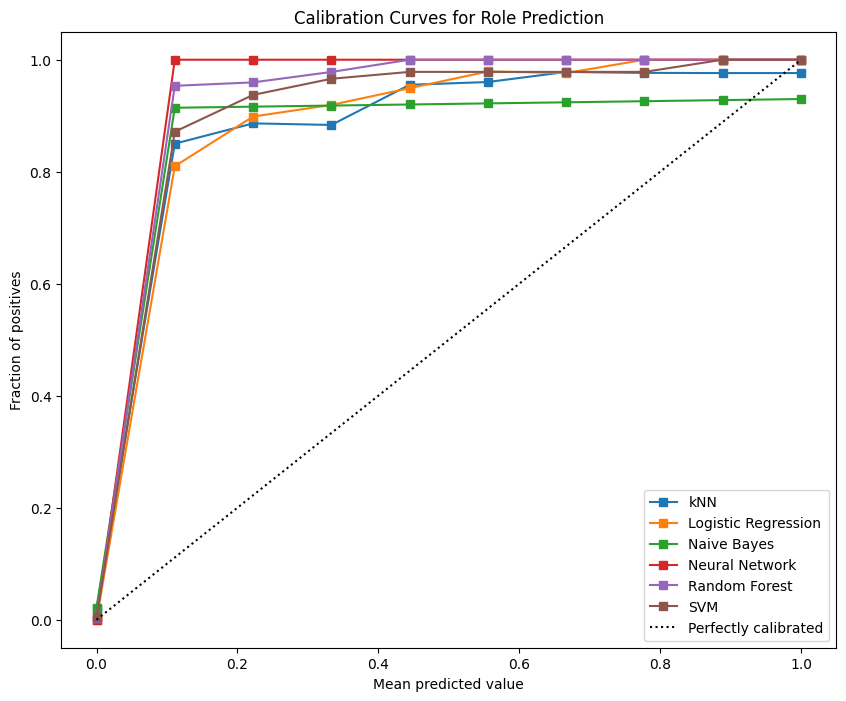

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.1

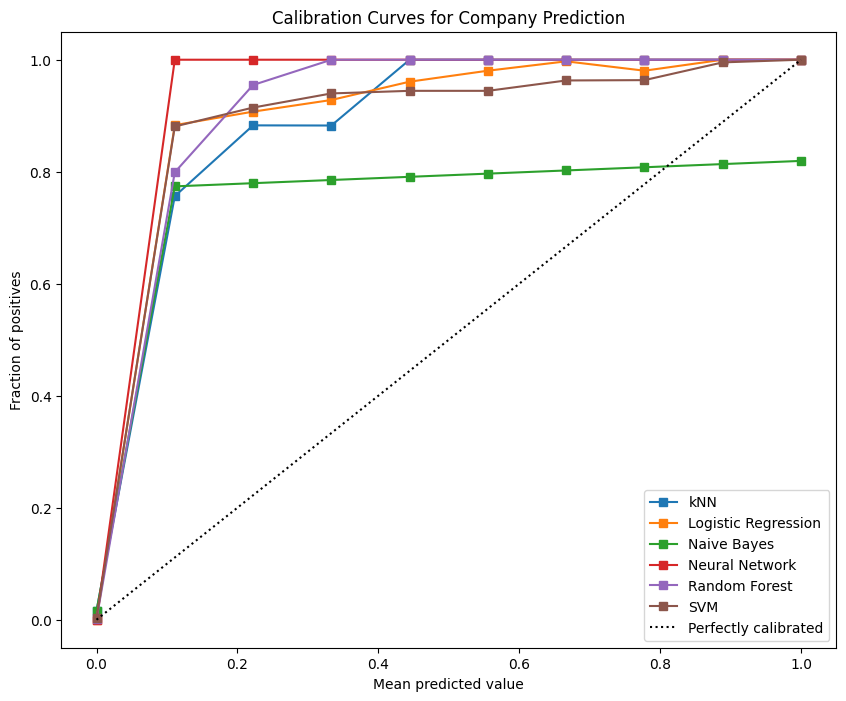

In [ ]:
# Example usage
plot_calibration_curve(role_models, X_role_test, Y_role_test, "Role Prediction", role_class_labels)
plot_calibration_curve(company_models, X_company_test, Y_company_test, "Company Prediction", company_class_labels)

In [ ]:
def plot_learning_curves_multiple(models, X_train, Y_train, X_test, Y_test, title):
    # Convert one-hot encoded Y_train and Y_test to class labels if necessary
    if len(Y_train.shape) != 1:
        Y_train = np.argmax(Y_train.values, axis=1) if hasattr(Y_train, 'values') else np.argmax(Y_train, axis=1)
    if len(Y_test.shape) != 1:
        Y_test = np.argmax(Y_test.values, axis=1) if hasattr(Y_test, 'values') else np.argmax(Y_test, axis=1)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['blue', 'orange', 'cyan', 'green', 'purple', 'red', 'yellow', 'magenta', 'dodgerblue', 'slategray', 'thistle', 'olive']
    i = 0

    for idx, (model_name, model) in enumerate(models.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            model,
            X_train,
            Y_train,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy'
        )

        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        ax.plot(train_sizes, train_mean, label=f'Training Accuracy - {model_name}', color=colors[i])
        i += 1
        ax.plot(train_sizes, test_mean, label=f'Testing Accuracy - {model_name}', color=colors[i])
        i += 1

    ax.set_title(title)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Accuracy')
    ax.grid()

    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)

    plt.subplots_adjust(right=0.8)

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


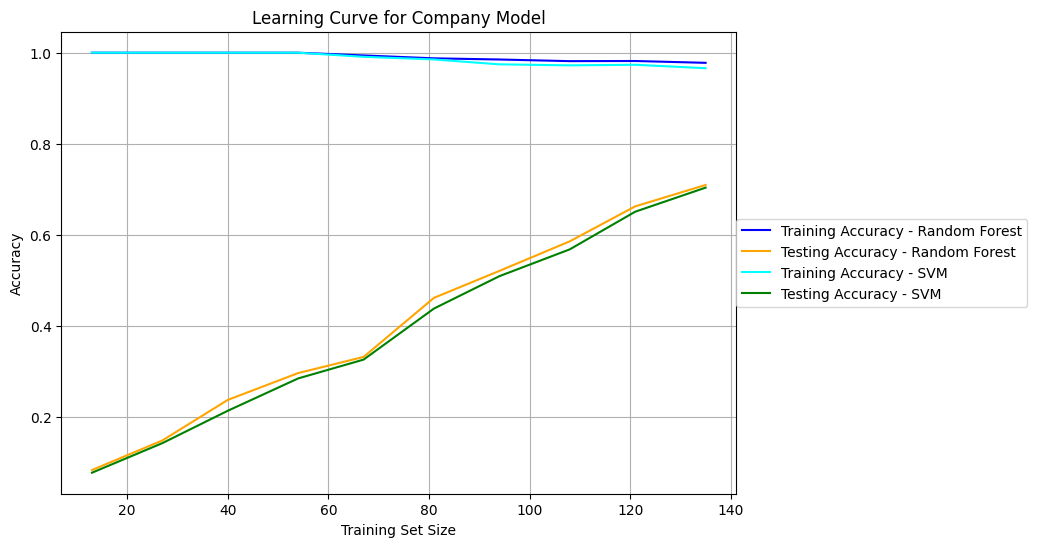

In [ ]:
models = {
    'Random Forest': company_models['Random Forest'],
    'SVM': company_models['SVM']
}
plot_learning_curves_multiple(models, X_company_train, Y_company_train, X_company_test, Y_company_test, 'Learning Curve for Company Model')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


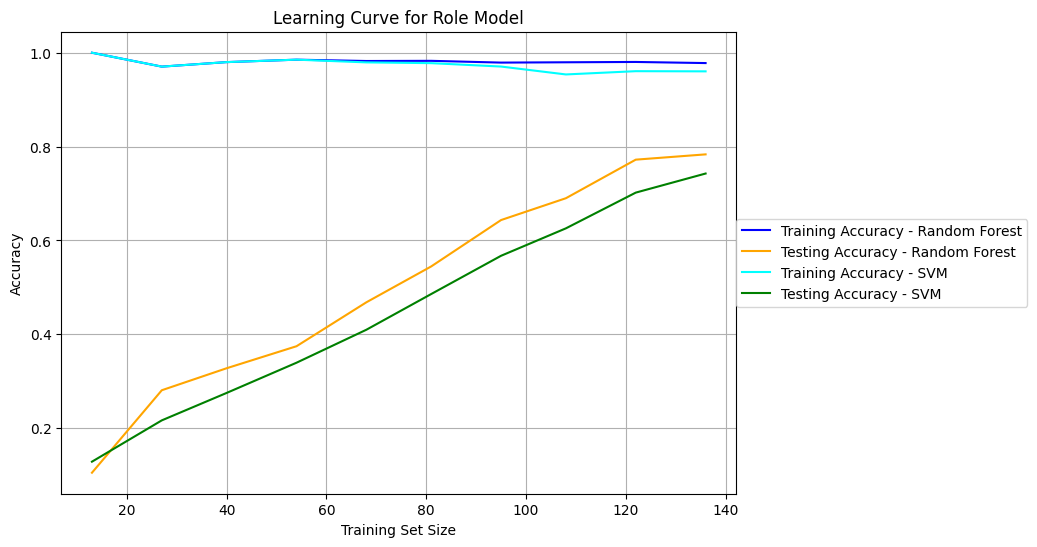

In [ ]:
models = {
    'Random Forest': role_models['Random Forest'],
    'SVM': role_models['SVM']
}
plot_learning_curves_multiple(models, X_role_train, Y_role_train, X_role_test, Y_role_test, 'Learning Curve for Role Model')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


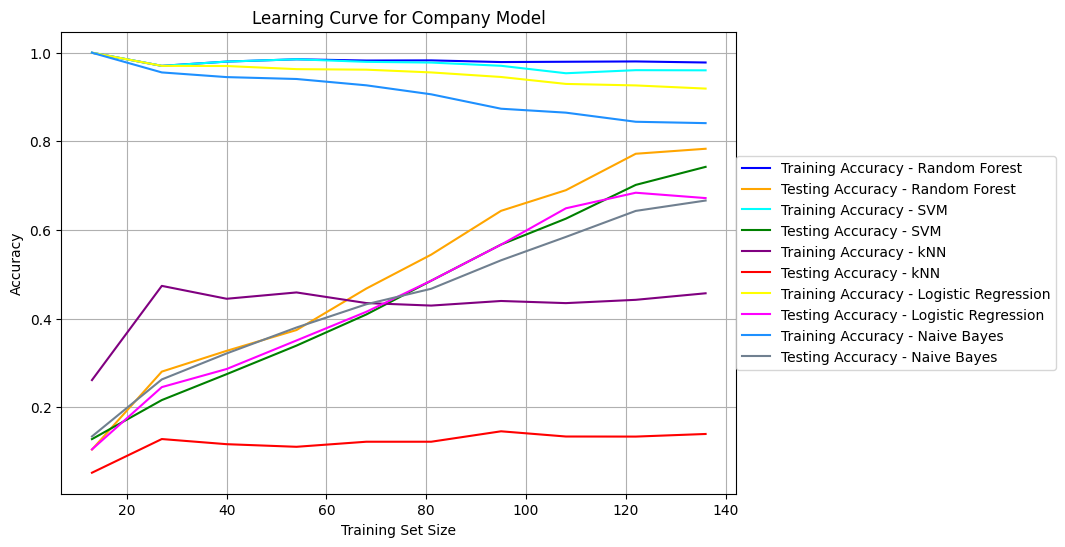

In [ ]:
models = {
    'Random Forest': role_models['Random Forest'],
    'SVM': role_models['SVM'],
    'kNN': role_models['kNN'],
    'Logistic Regression': role_models['Logistic Regression'],
    'Naive Bayes': role_models['Naive Bayes']
}
plot_learning_curves_multiple(models, X_role_train, Y_role_train, X_role_test, Y_role_test, 'Learning Curve for Company Model')

In [ ]:
models = {
    'Random Forest': company_models['Random Forest'],
    'SVM': company_models['SVM'],
    'kNN': company_models['kNN'],
    'Logistic Regression': company_models['Logistic Regression'],
    'Naive Bayes': company_models['Naive Bayes']
}
plot_learning_curves_multiple(company_models, X_company_train, Y_company_train, X_company_test, Y_company_test, 'Learning Curve for Company Model')